In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os, sys
import torch
import optuna
import ruamel.yaml as yaml
import re
from scipy.stats import mannwhitneyu,ks_2samp

In [4]:
plot_dir = "/Users/eric/repos/gohr/misc/ml_plots/"

if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [10]:
class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

# Location of rule runs
#rule_runs_path = "/Users/eric/repos/gohr/active/outputs/rd_import/"
rule_runs_path = "/Users/eric/repos/gohr/active/outputs/test/other_position_A/"
#rule_runs_path="/Users/eric/repos/gohr/active/outputs/hidden_sizes_500_500_10993623/"

runs_to_analyze = ["naive_bd_ad_n6"]
# runs_to_analyze = ["naive_bd_ad_n2","naive_bd_ad_n4","naive_bd_ad_n6","naive_bd_ad_n8",
#                    "naive_bs_ad_n2","naive_bs_ad_n4","naive_bs_ad_n6","naive_bs_ad_n8",
#                    "naive_bd_as_n2","naive_bd_as_n4","naive_bd_as_n6","naive_bd_as_n8",
#                    "naive_bda_as_n2","naive_bda_as_n4","naive_bda_as_n6","naive_bda_as_n8",
#                    "naive_bs_as_n2","naive_bs_as_n4","naive_bs_as_n6","naive_bs_as_n8",
#                    "naive_bsd_asd_n2","naive_bsd_asd_n4","naive_bsd_asd_n6","naive_bsd_asd_n8"]

# Create lists that will hold dataframes for concatenation
episode_df_list = []
terminal_results_list = []
placeholder_value = 50000
delta_horizon=100
# Loop over the specified rule runs
for run in runs_to_analyze:
    # Form complete run path
    run_path = rule_runs_path+run
    # Get the experiments for that run (each one is a set of trials for a particular rule)
    experiments = [name for name in os.listdir(run_path) if name!=".DS_Store"]

    # Loop over the experiments
    for experiment in experiments:
        # Get the cluster id
        cluster_trial = experiment.split("_")[0]
        cluster_process = experiment.split("_")[1]
        cluster_id = cluster_trial+"_"+cluster_process
        # String length may vary
        id_str_length = len(cluster_id)
        # Get the corresponding rule name
        rule_name = experiment[id_str_length+1:]
        # For complete experiment path
        experiment_path = os.path.join(run_path,experiment)
        
        trials = [name for name in os.listdir(experiment_path) if name!=".DS_Store"]

        for trial in trials:
            trial_path = os.path.join(experiment_path,trial)
            # Get parameters
            yaml_path = os.path.join(trial_path,"data.yaml")
            with open(yaml_path, 'r') as param_file:
                args = yaml.load(param_file, Loader=SafeLoaderIgnoreUnknown)
                featurization =args["FEATURIZATION"]
            # Import episodic data and process relevant columns
            episodic_data_path = os.path.join(trial_path,"episode_data.csv")
            trial_results = pd.read_csv(episodic_data_path)
            #move_results = pd.read_csv(move_data_path,index_col=0,usecols=['episode','time','reward'])
            
            # Episode processing
            trial_results["rule"]=rule_name
            trial_results["params"]=run
            trial_results["memory"]=int(run[-1])
            trial_results["experiment_id"]=cluster_id
            trial_results["trial"]=trial
            trial_results["featurization"]=featurization
            trial_results["ep_error"]=-1*trial_results["reward"]
            trial_results["cumulative_error"] = trial_results.ep_error.cumsum()
            #if trial_results.episode.max()!=1999:
                #print(trial_results.cluster_id.unique())
            #    continue
            delta = trial_results.cumulative_error.iloc[-1]-trial_results.cumulative_error.iloc[-delta_horizon]
            #trial_results["100_ep_delta"]=delta
            converged = (delta/(delta_horizon*9+delta))<0.01
            #trial_results["converged"]=converged
            term_entry = trial_results.iloc[-1].to_frame().transpose()
            tce = term_entry.cumulative_error
            term_entry["converged"]=converged
            if converged:
                adj_error=tce
            else:
                adj_error=placeholder_value
            term_entry["adj_cumulative_error"]=adj_error
            term_entry["delta"]=delta
            terminal_results_list.append(term_entry)
            test_ser = trial_results.iloc[-1]
            episode_df_list.append(trial_results)
            
# Concatenate everything into one dataframe
episode_results_df = pd.concat(episode_df_list,ignore_index=True)
terminal_results_df = pd.concat(terminal_results_list,ignore_index=True)

In [11]:
episode_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
0,0,-86,position_A,naive_bd_ad_n6,6,9999999_0,0,NAIVE_N_BD_AD,86,86
1,1,-93,position_A,naive_bd_ad_n6,6,9999999_0,0,NAIVE_N_BD_AD,93,179
2,2,-60,position_A,naive_bd_ad_n6,6,9999999_0,0,NAIVE_N_BD_AD,60,239
3,3,-30,position_A,naive_bd_ad_n6,6,9999999_0,0,NAIVE_N_BD_AD,30,269
4,4,-22,position_A,naive_bd_ad_n6,6,9999999_0,0,NAIVE_N_BD_AD,22,291


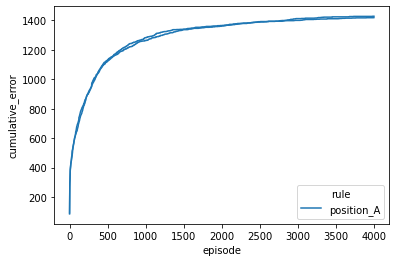

In [13]:
ax=sns.lineplot(data=episode_results_df,y="cumulative_error",x="episode",estimator=None,hue="rule",units='trial')

In [12]:
terminal_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error,converged,adj_cumulative_error,delta
0,3999,0,position_A,naive_bd_ad_n6,6,9999999_0,0,NAIVE_N_BD_AD,0,1427,True,1427,1
1,3999,0,position_A,naive_bd_ad_n6,6,9999999_0,1,NAIVE_N_BD_AD,0,1418,True,1418,1


In [13]:
complete_list = episode_results_df.rule.unique()
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,2500]},
                {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,2500]}, 
                {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,4000]},
                {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
                {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top"],"y":[0,1500]}
                ]

steps = terminal_results_df.memory.unique()
print(steps)
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
#feats = ["NAIVE_N_BDa_AS","NAIVE_N_BD_AS","NAIVE_N_BD_AD"]
#feats = ["NAIVE_N_BSD_ASD"]

[2 4 6 8]


In [4]:
# REINFORCE
complete_list = episode_results_df.rule.unique()
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,30000]},
                {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,30000]}, 
                {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,30000]},
                {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,600]},
                {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top"],"y":[0,5000]}
                ]

steps = terminal_results_df.memory.unique()
print(steps)
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
#feats = ["NAIVE_N_BDa_AS","NAIVE_N_BD_AS","NAIVE_N_BD_AD"]
#feats = ["NAIVE_N_BSD_ASD"]

[2 4 6 8]


In [5]:
reduced_results = episode_results_df.query("episode%20==0")
reduced_results.head()


,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
0,0,-5,1_2_shape_4m,naive_bd_ad_n2,2,11024066_96,0,NAIVE_N_BD_AD,5,5
20,20,-7,1_2_shape_4m,naive_bd_ad_n2,2,11024066_96,0,NAIVE_N_BD_AD,7,183
40,40,-12,1_2_shape_4m,naive_bd_ad_n2,2,11024066_96,0,NAIVE_N_BD_AD,12,404
60,60,-15,1_2_shape_4m,naive_bd_ad_n2,2,11024066_96,0,NAIVE_N_BD_AD,15,587
80,80,-5,1_2_shape_4m,naive_bd_ad_n2,2,11024066_96,0,NAIVE_N_BD_AD,5,784


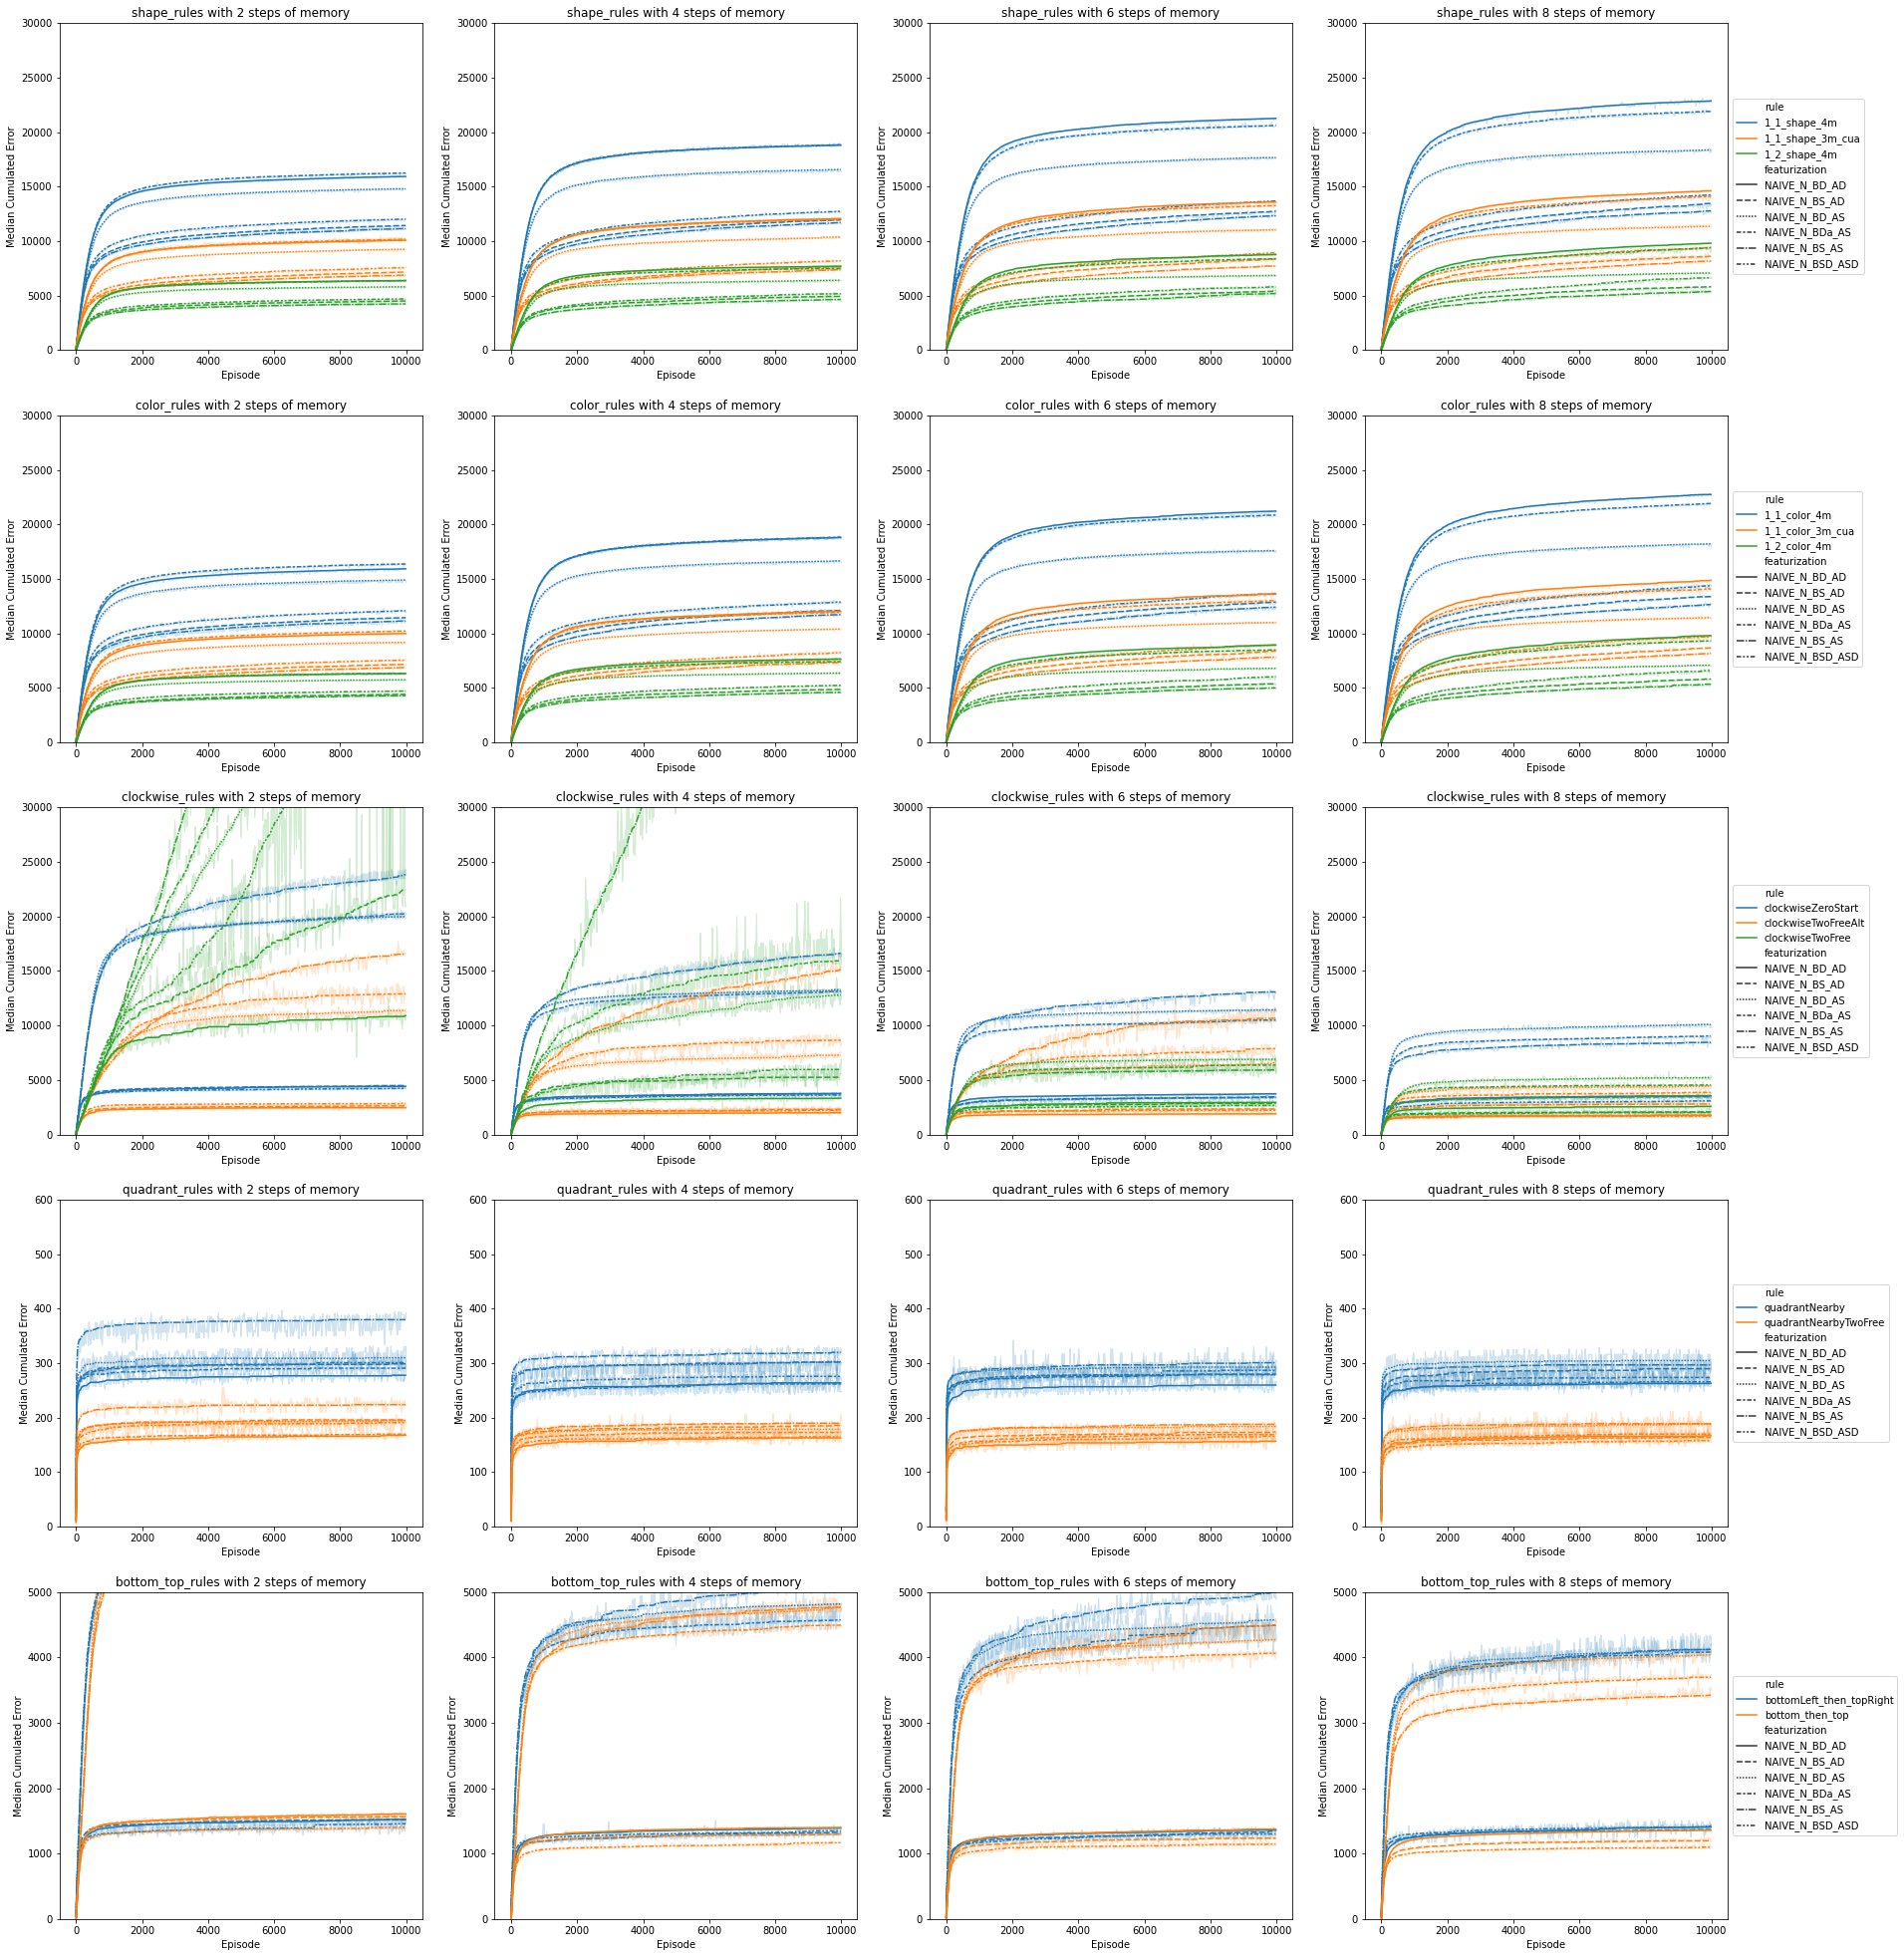

In [6]:
# Create a figure grid for all results
fig = plt.figure(figsize=(30,35))
for idx,step in enumerate(steps):
    #results_df = episode_results_df[episode_results_df.memory==step]
    results_df = reduced_results[reduced_results.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=1, estimator=np.median,hue="rule",hue_order=sub_list,style="featurization",style_order=feats,legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=1, estimator=np.median,hue="rule",hue_order=sub_list,style="featurization",style_order=feats)
            #errorbar=("ci",95),n_boot=1
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(np.array(sub_dict["y"]))
        ax.set_ylabel("Median Cumulated Error")
        ax.set_xlabel("Episode")
plt.savefig(plot_dir+'reinforce_init_ml_6_ways.pdf',bbox_inches='tight',facecolor='w')
#plt.savefig(plot_dir+'ml_6_ways_base_rules.pdf',bbox_inches='tight',facecolor='w')

In [9]:
terminal_results_df.head()

,episode,reward,cluster_id,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
0,1999,0.0,10726599_117_0,bottomLeft_then_topRight,naive_bd_ad_n2,2,10726599_117,0,NAIVE_N_BD_AD,-0.0,433.0
1,1999,0.0,10726599_117_1,bottomLeft_then_topRight,naive_bd_ad_n2,2,10726599_117,1,NAIVE_N_BD_AD,-0.0,435.0
2,1999,0.0,10726599_117_4,bottomLeft_then_topRight,naive_bd_ad_n2,2,10726599_117,4,NAIVE_N_BD_AD,-0.0,418.0
3,1999,0.0,10726599_117_3,bottomLeft_then_topRight,naive_bd_ad_n2,2,10726599_117,3,NAIVE_N_BD_AD,-0.0,444.0
4,1999,0.0,10726599_117_2,bottomLeft_then_topRight,naive_bd_ad_n2,2,10726599_117,2,NAIVE_N_BD_AD,-0.0,465.0


In [10]:
complete_rules = ["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m",
                "1_1_color_4m","1_1_color_3m_cua","1_2_color_4m", 
                "clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree",
                "quadrantNearby","quadrantNearbyTwoFree",
                "bottomLeft_then_topRight","bottom_then_top"]
base_rules = ["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"]
feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
steps = [2,4,6,8]

['1_1_shape_4m', '1_1_shape_3m_cua', '1_2_shape_4m', '1_1_color_4m', '1_1_color_3m_cua', '1_2_color_4m', 'clockwiseZeroStart', 'clockwiseTwoFreeAlt', 'clockwiseTwoFree', 'quadrantNearby', 'quadrantNearbyTwoFree', 'bottomLeft_then_topRight', 'bottom_then_top']


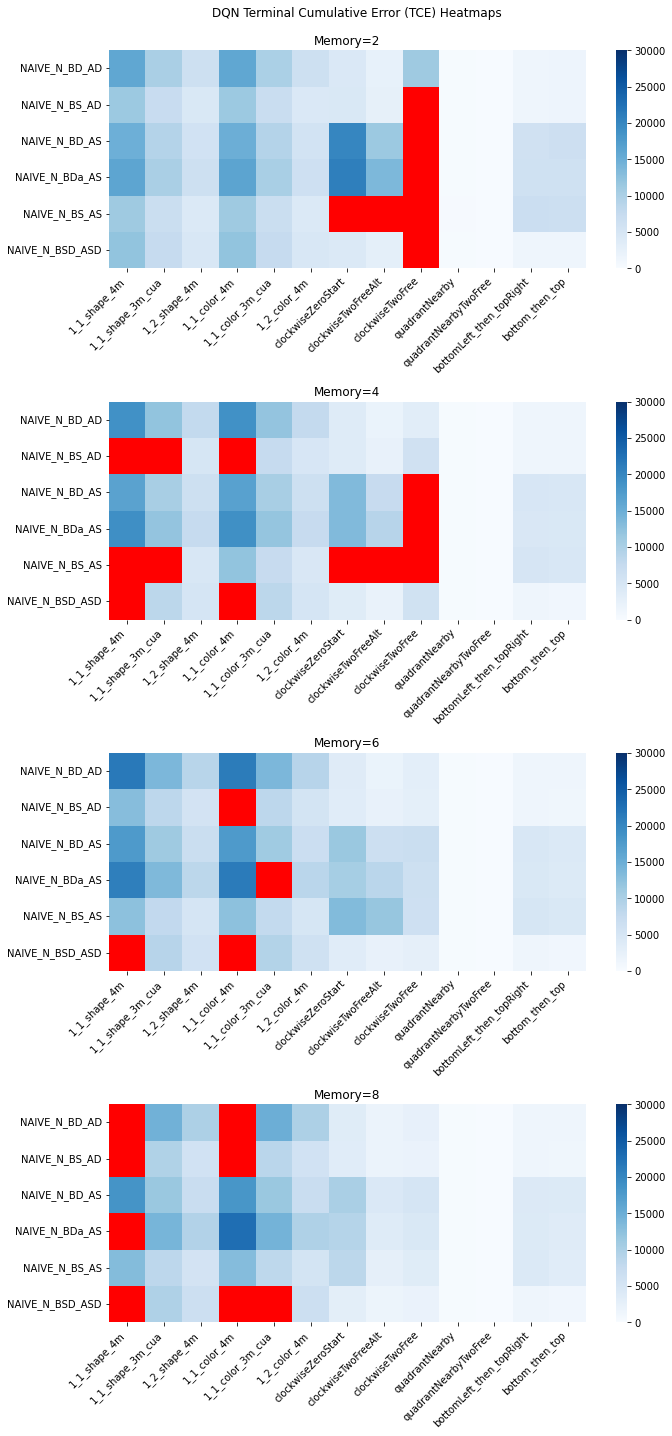

In [12]:
chosen_rules = complete_rules
num_feats = len(feats)
num_rules = len(chosen_rules)
num_steps = len(steps)
tce_heatmap = np.empty((num_steps,num_feats,num_rules))

for i in range(num_feats):
    curr_feat = feats[i]
    for j in range(num_rules):
        curr_rule = chosen_rules[j]
        for k in range(num_steps):
            curr_step = steps[k]
            curr_df = terminal_results_df.query("rule==@curr_rule & featurization==@curr_feat & memory==@curr_step").copy()
            errors = curr_df.adj_cumulative_error.to_numpy(copy=True)
            med_err = np.median(errors)
            tce_heatmap[k][i][j]=med_err
print(chosen_rules)

fig = plt.figure(figsize=(10,20))
gs = GridSpec(nrows = len(steps),ncols=1)
green = sns.light_palette("seagreen", reverse=True, as_cmap=True)
blue = sns.color_palette("Blues",as_cmap=True)
blue.set_over('red')
for i,step in enumerate(steps):
    ax = fig.add_subplot(gs[i,0])
    sns.heatmap(ax=ax,data=tce_heatmap[i],cmap=blue,vmin=0,vmax=30000,yticklabels=feats,xticklabels=chosen_rules)#,annot=True,yticklabels=sorted_rules_labeled,linewidth=.5,vmin=0,vmax=alpha/comparisons,cmap=green,cbar=False,square=True,fmt='.5f')
    ax.set_title("Memory={}".format(str(step)))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment="right")
fig.suptitle('DQN Terminal Cumulative Error (TCE) Heatmaps',x=0.5,y=.995,ha='center')
fig.tight_layout()
plt.savefig('dqn_initial_heatmap_2err_100ep.pdf',bbox_inches='tight',facecolor='w')

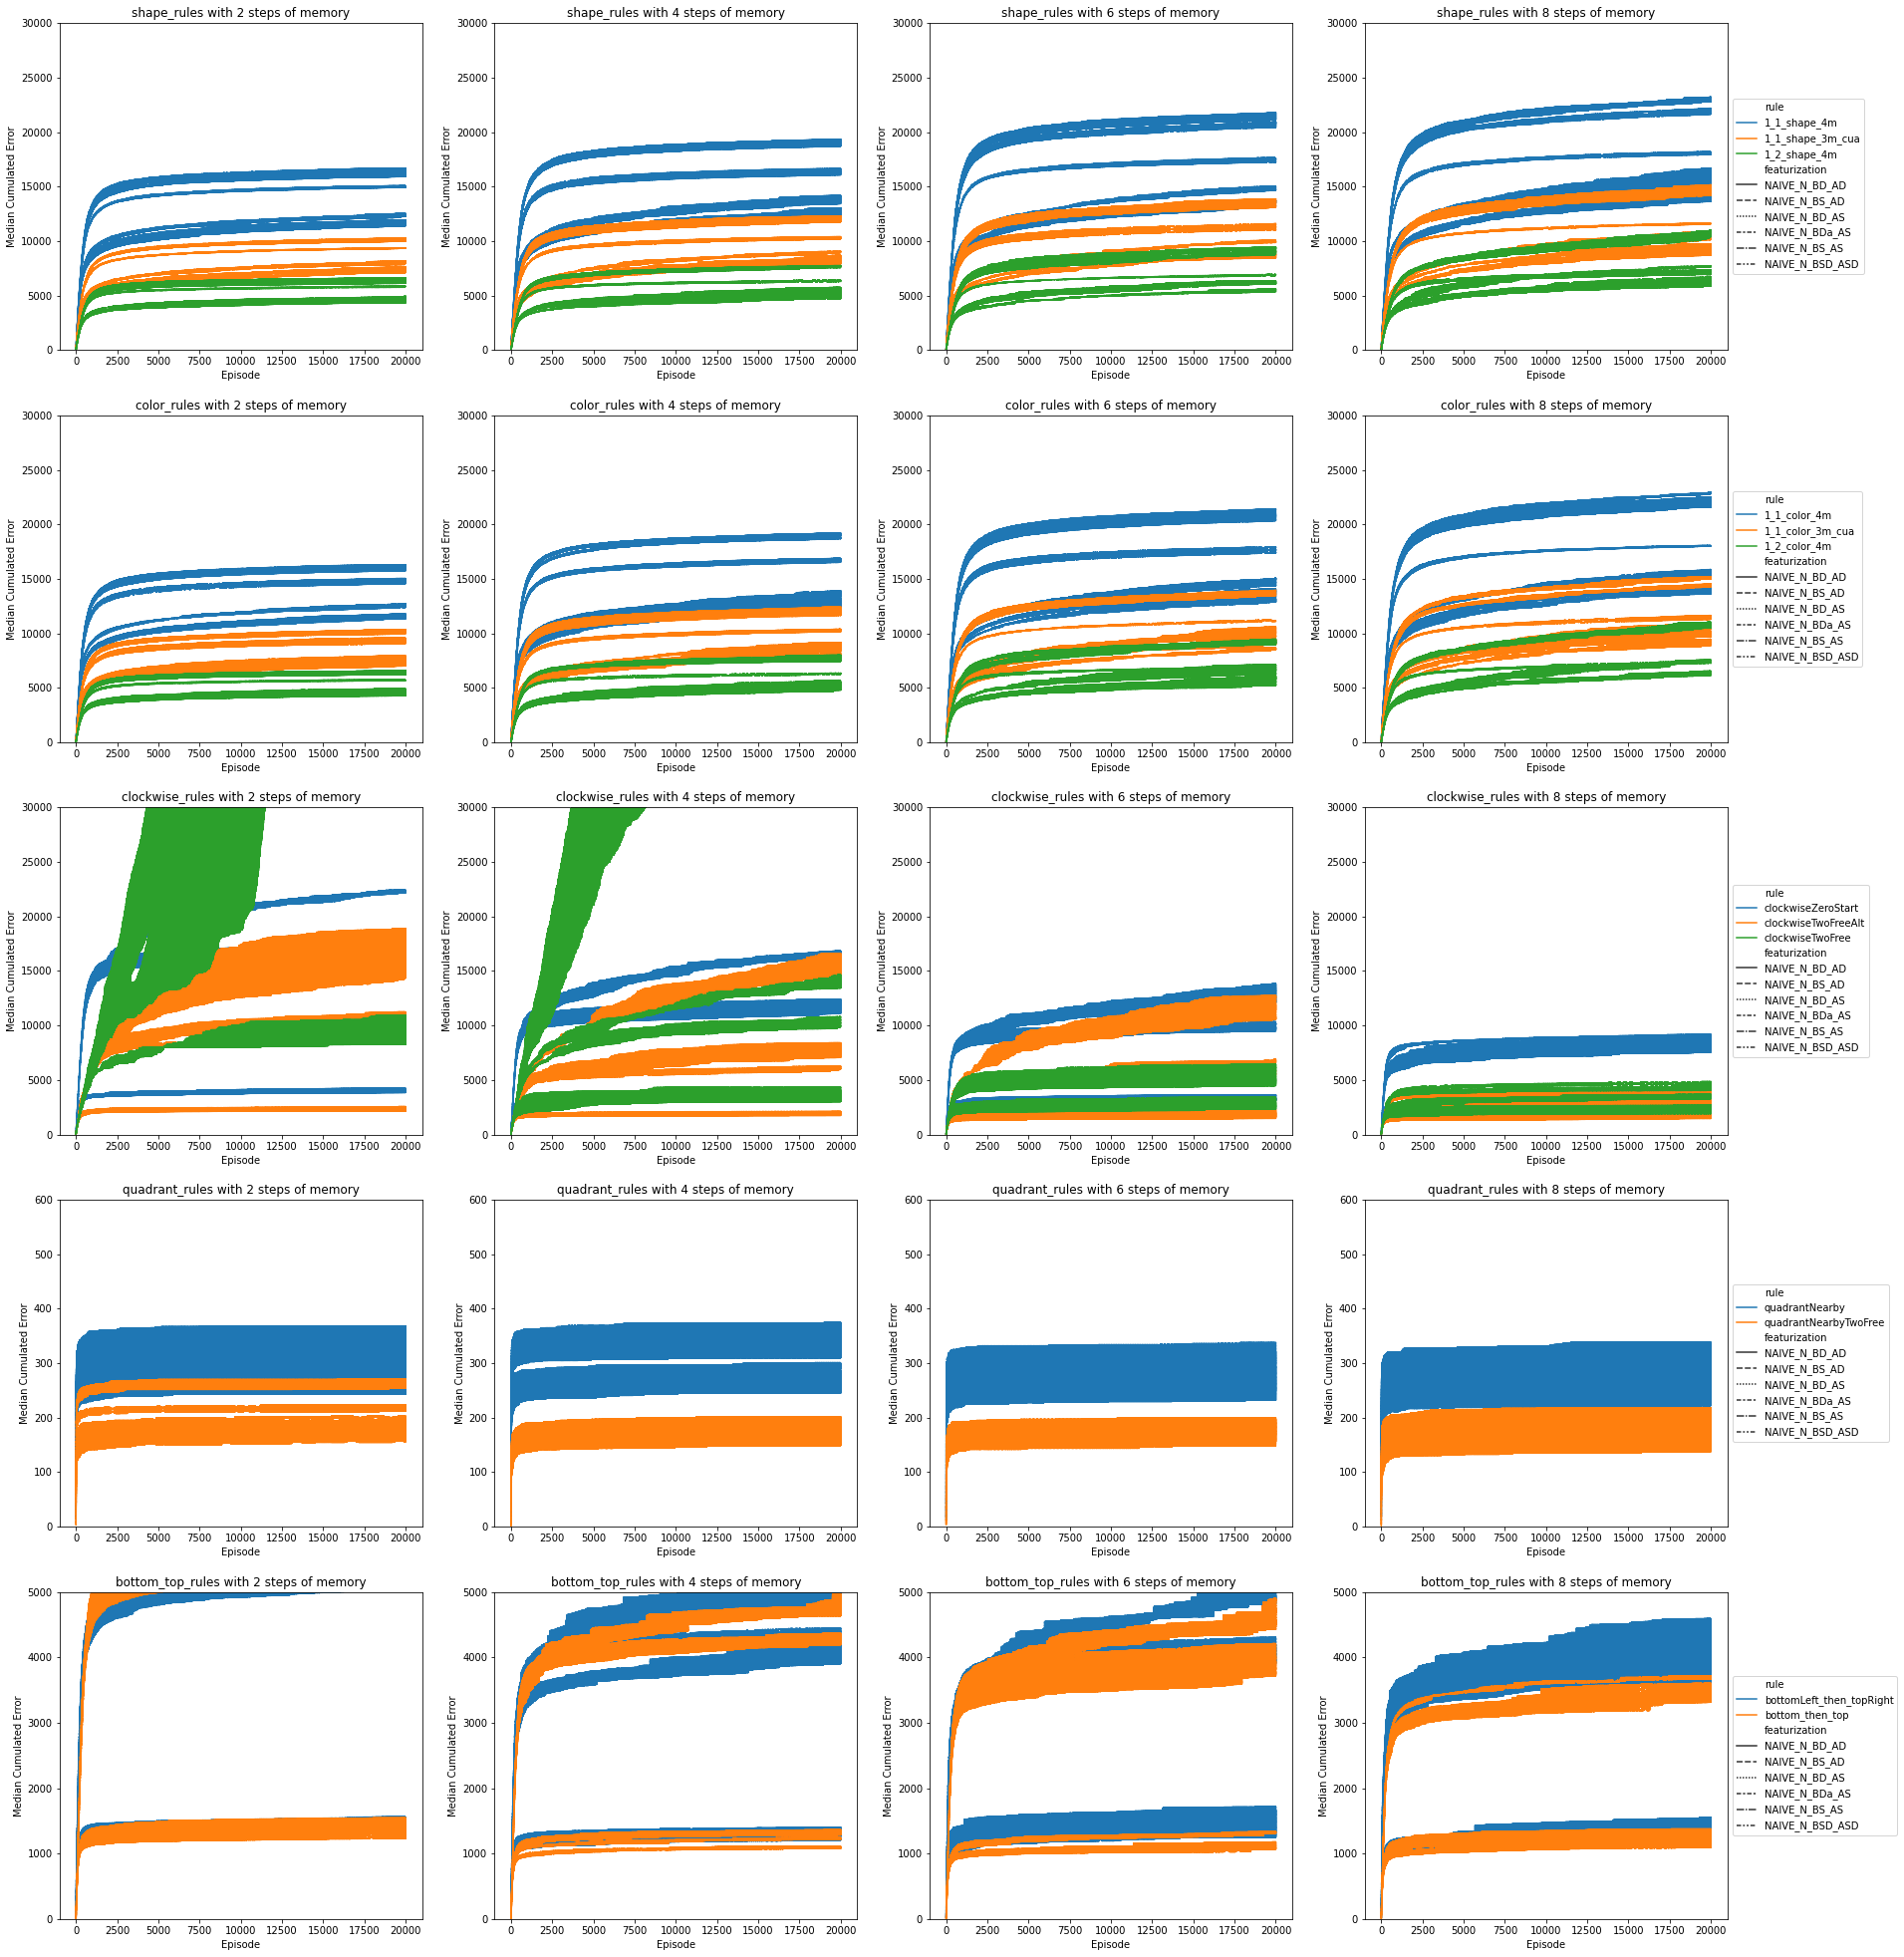

In [16]:
# Create a figure grid for all results (raw lines)
fig = plt.figure(figsize=(30,35))
for idx,step in enumerate(steps):
    results_df = episode_results_df[episode_results_df.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", estimator=None,hue="rule",hue_order=sub_list,style="featurization",style_order=feats,legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", estimator=None,hue="rule",hue_order=sub_list,style="featurization",style_order=feats)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])
        ax.set_ylabel("Median Cumulated Error")
        ax.set_xlabel("Episode")

#plt.savefig(plot_dir+'ml_6_ways_ep5000.pdf',bbox_inches='tight',facecolor='w')

In [9]:
feat_dir = plot_dir+"featurizations/"
if not os.path.exists(feat_dir):
    os.mkdir(feat_dir)

for feat in feats:
    temp_df = episode_results_df.query("featurization==@feat").copy()
    fig = plt.figure(figsize=(30,35))
    steps = terminal_results_df.memory.unique()
    gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
    for idx,step in enumerate(steps):
        results_df = temp_df.query("memory==@step")
        for i in range(len(rules_list)):
            sub_dict = rules_list[i]
            sub_list = sub_dict["rules"]
            name = sub_dict["name"]
            ax = fig.add_subplot(gs[i,idx])
            if not(step==8):
                ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", errorbar=("ci",95),estimator=np.median,n_boot=100,hue="rule",hue_order=sub_list,legend=False)
            else:
                ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", errorbar=("ci",95),estimator=np.median,n_boot=100,hue="rule",hue_order=sub_list)
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(name+" with {} steps of memory".format(str(step)))
            ax.set_ylim(sub_dict["y"])
            ax.set_ylabel("Median Cumulated Error")
            ax.set_xlabel("Episode")
    fig.suptitle("Featurization: "+feat,y=.995)
    fig.tight_layout()
    plt.savefig(feat_dir+feat+'_all_rules.pdf',bbox_inches='tight',facecolor='w')
    plt.close(fig)

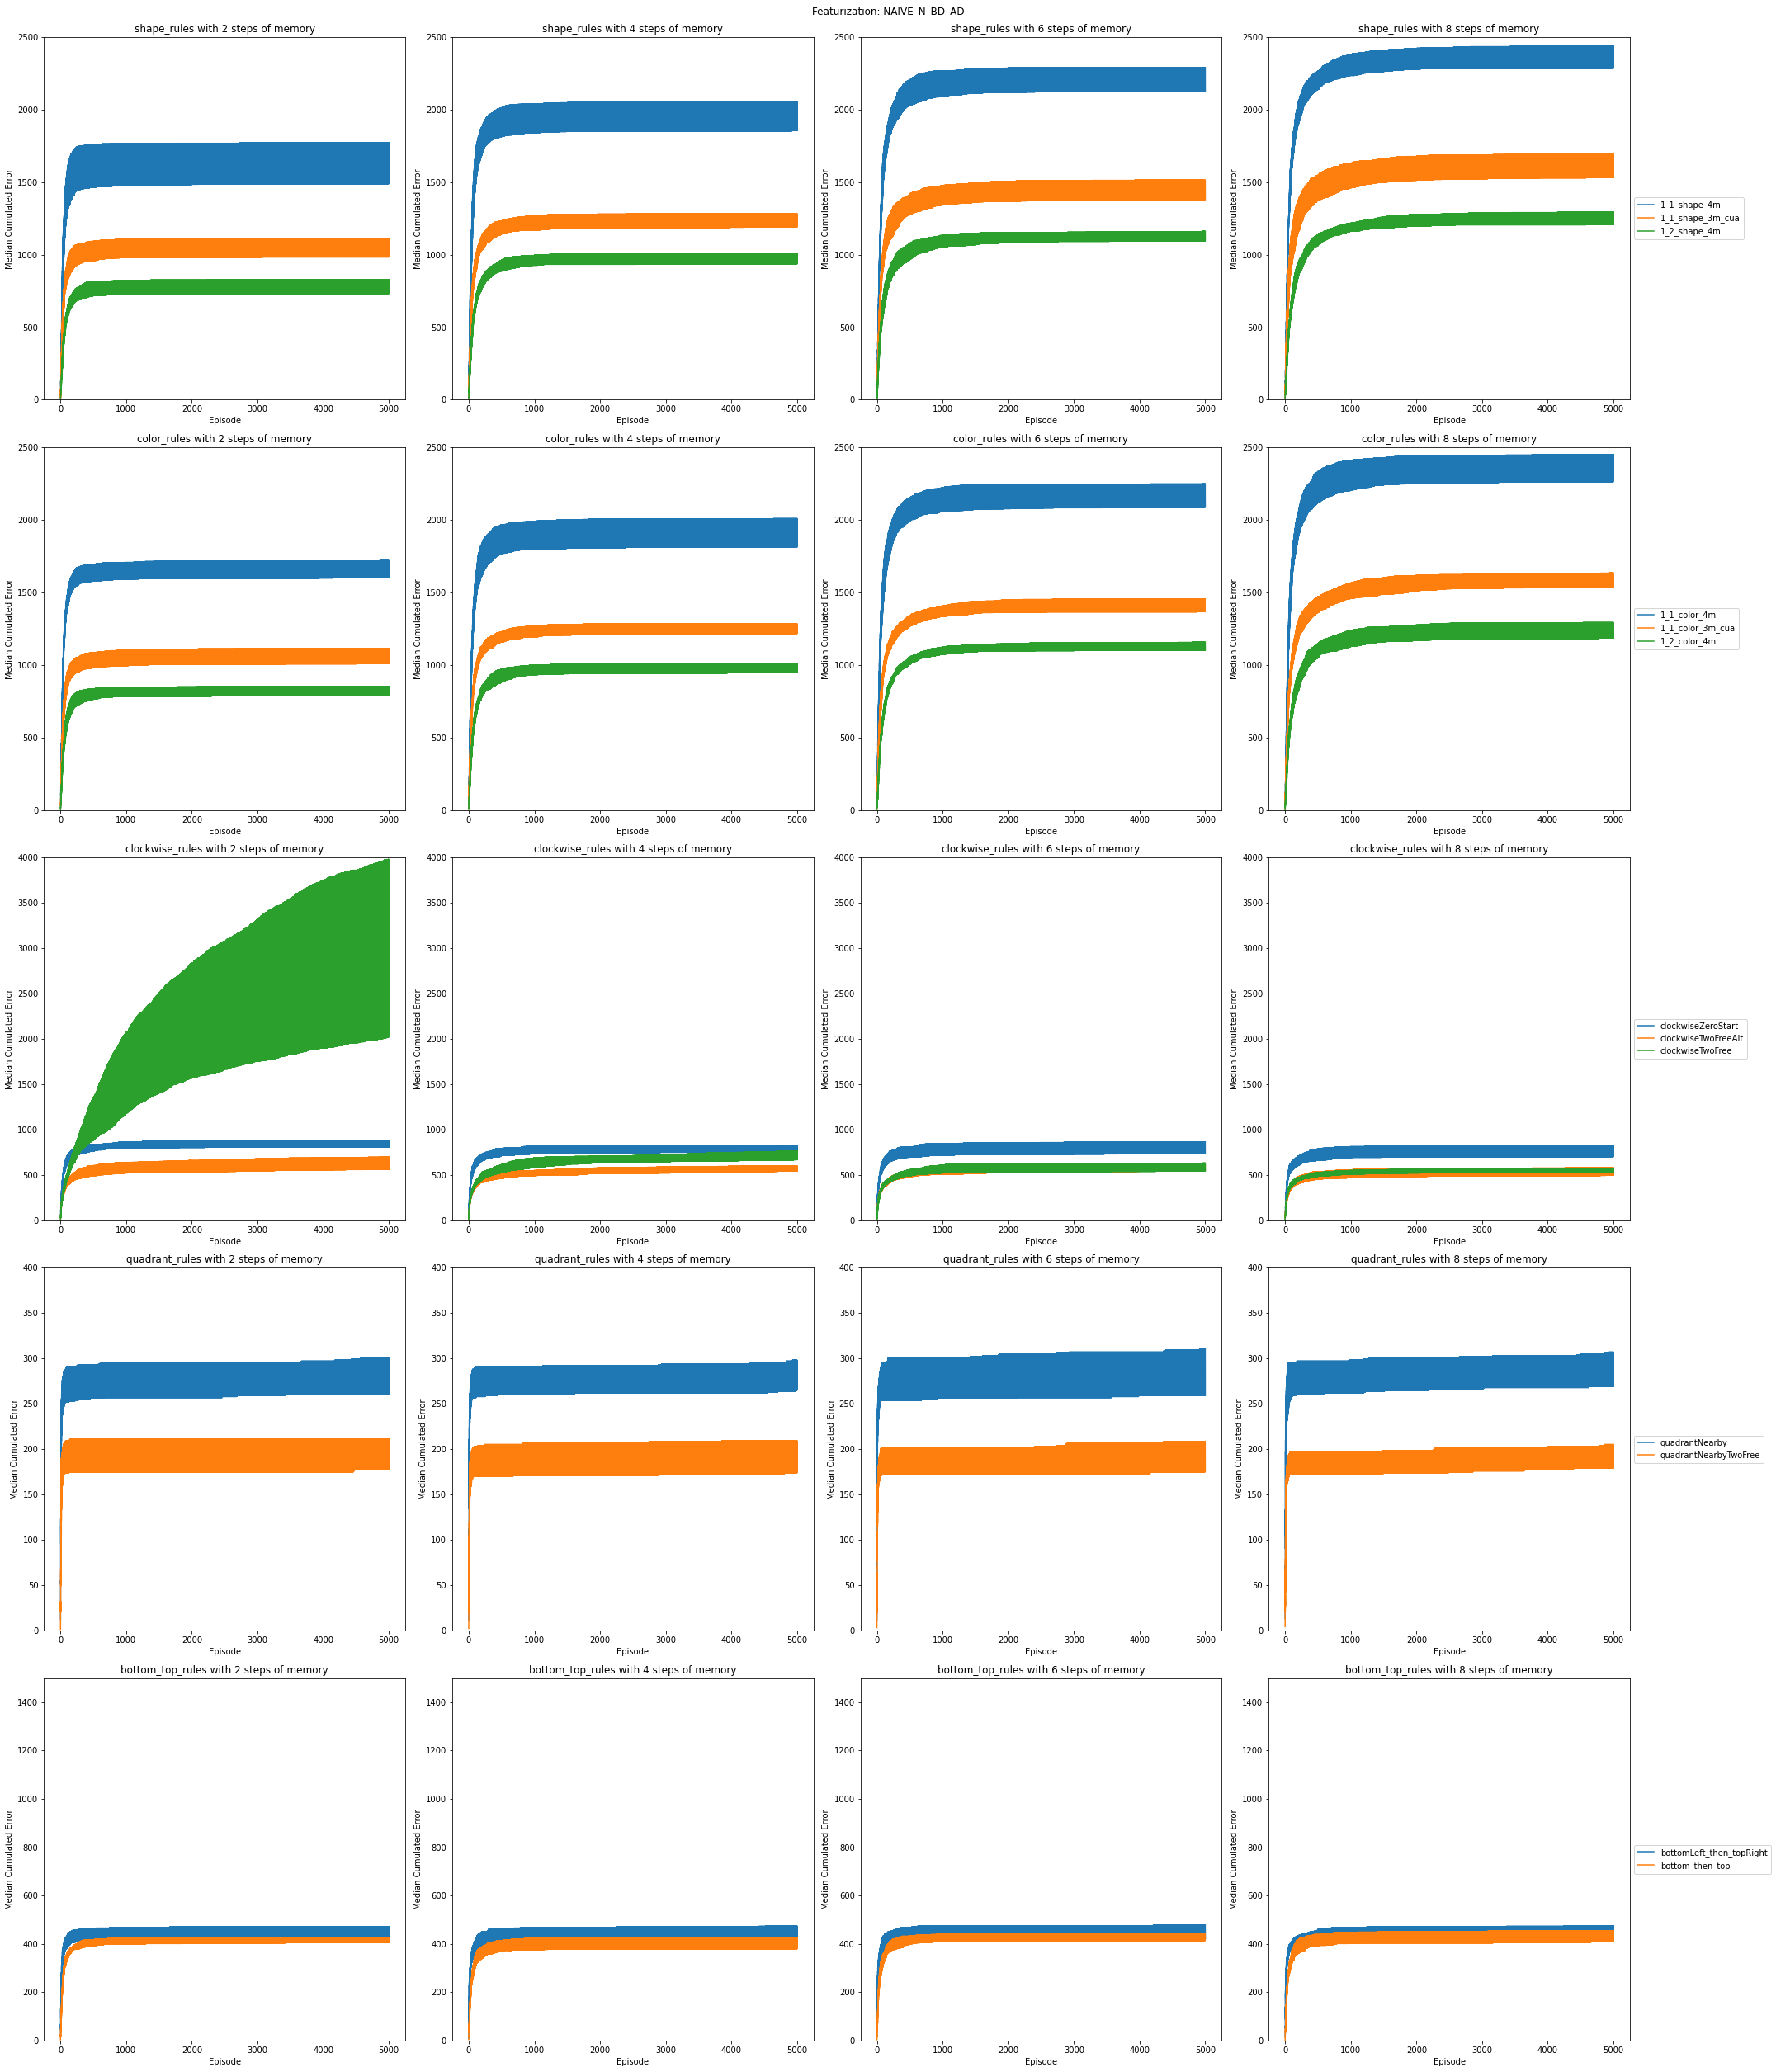

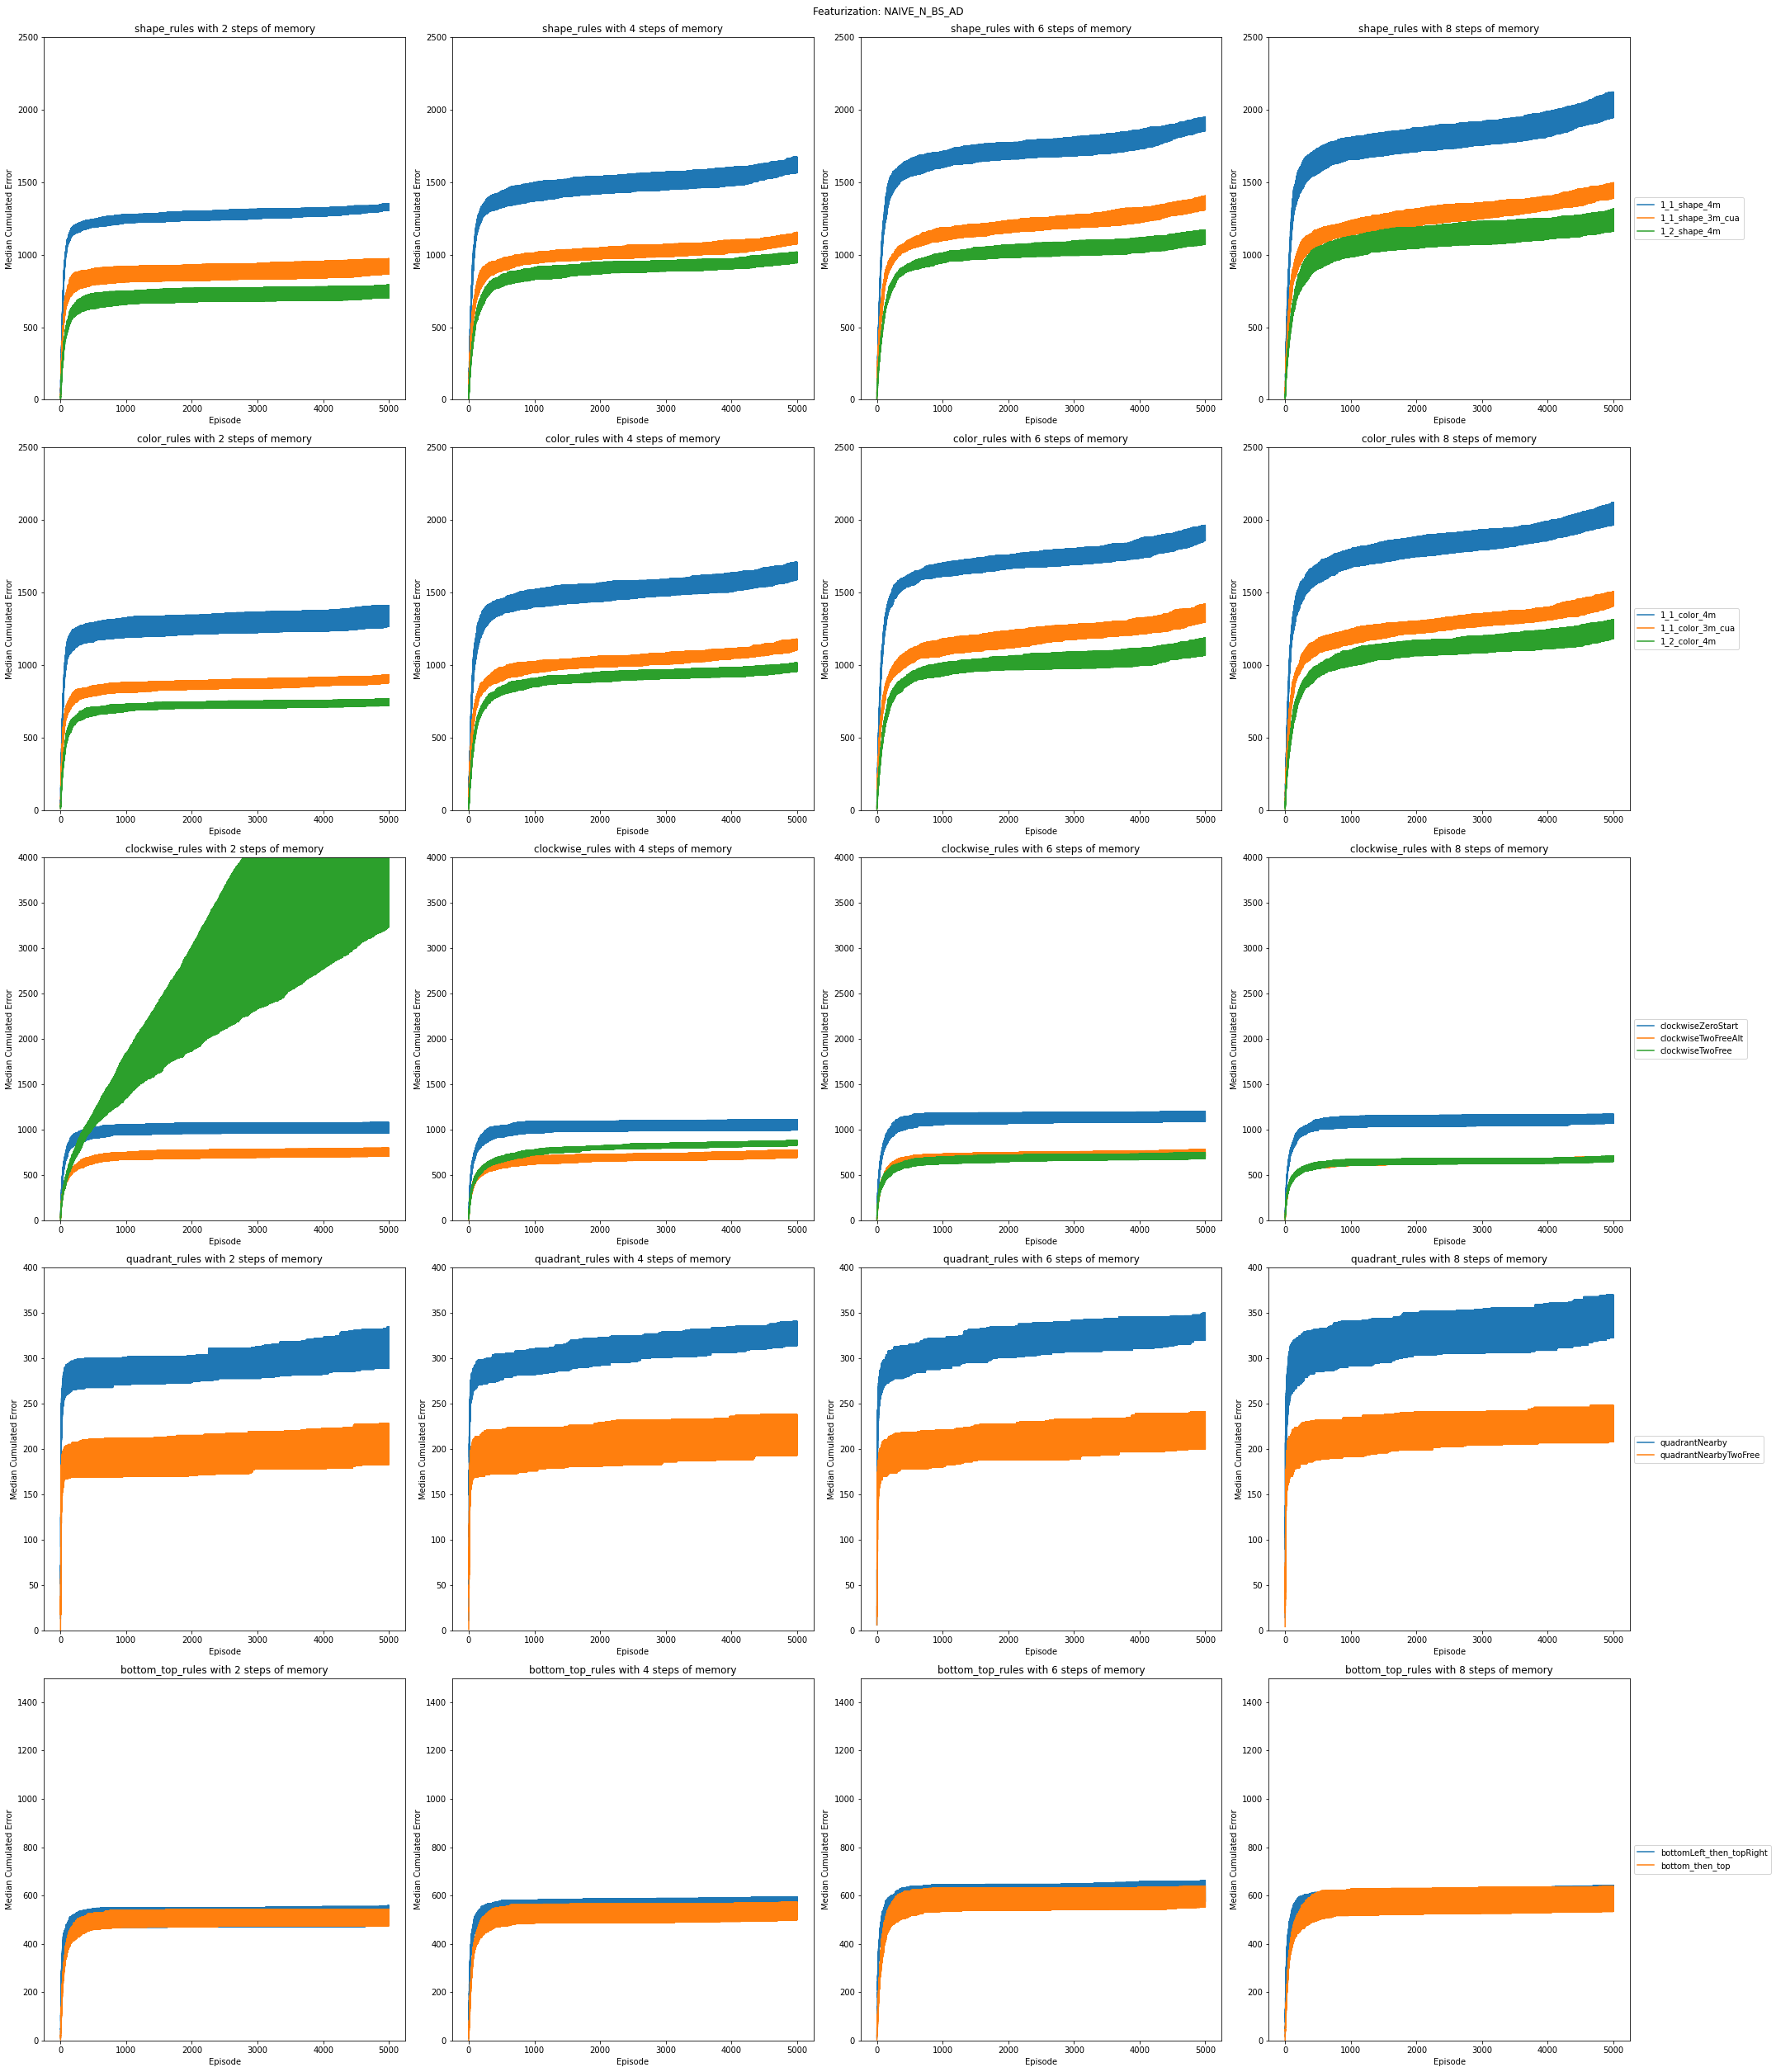

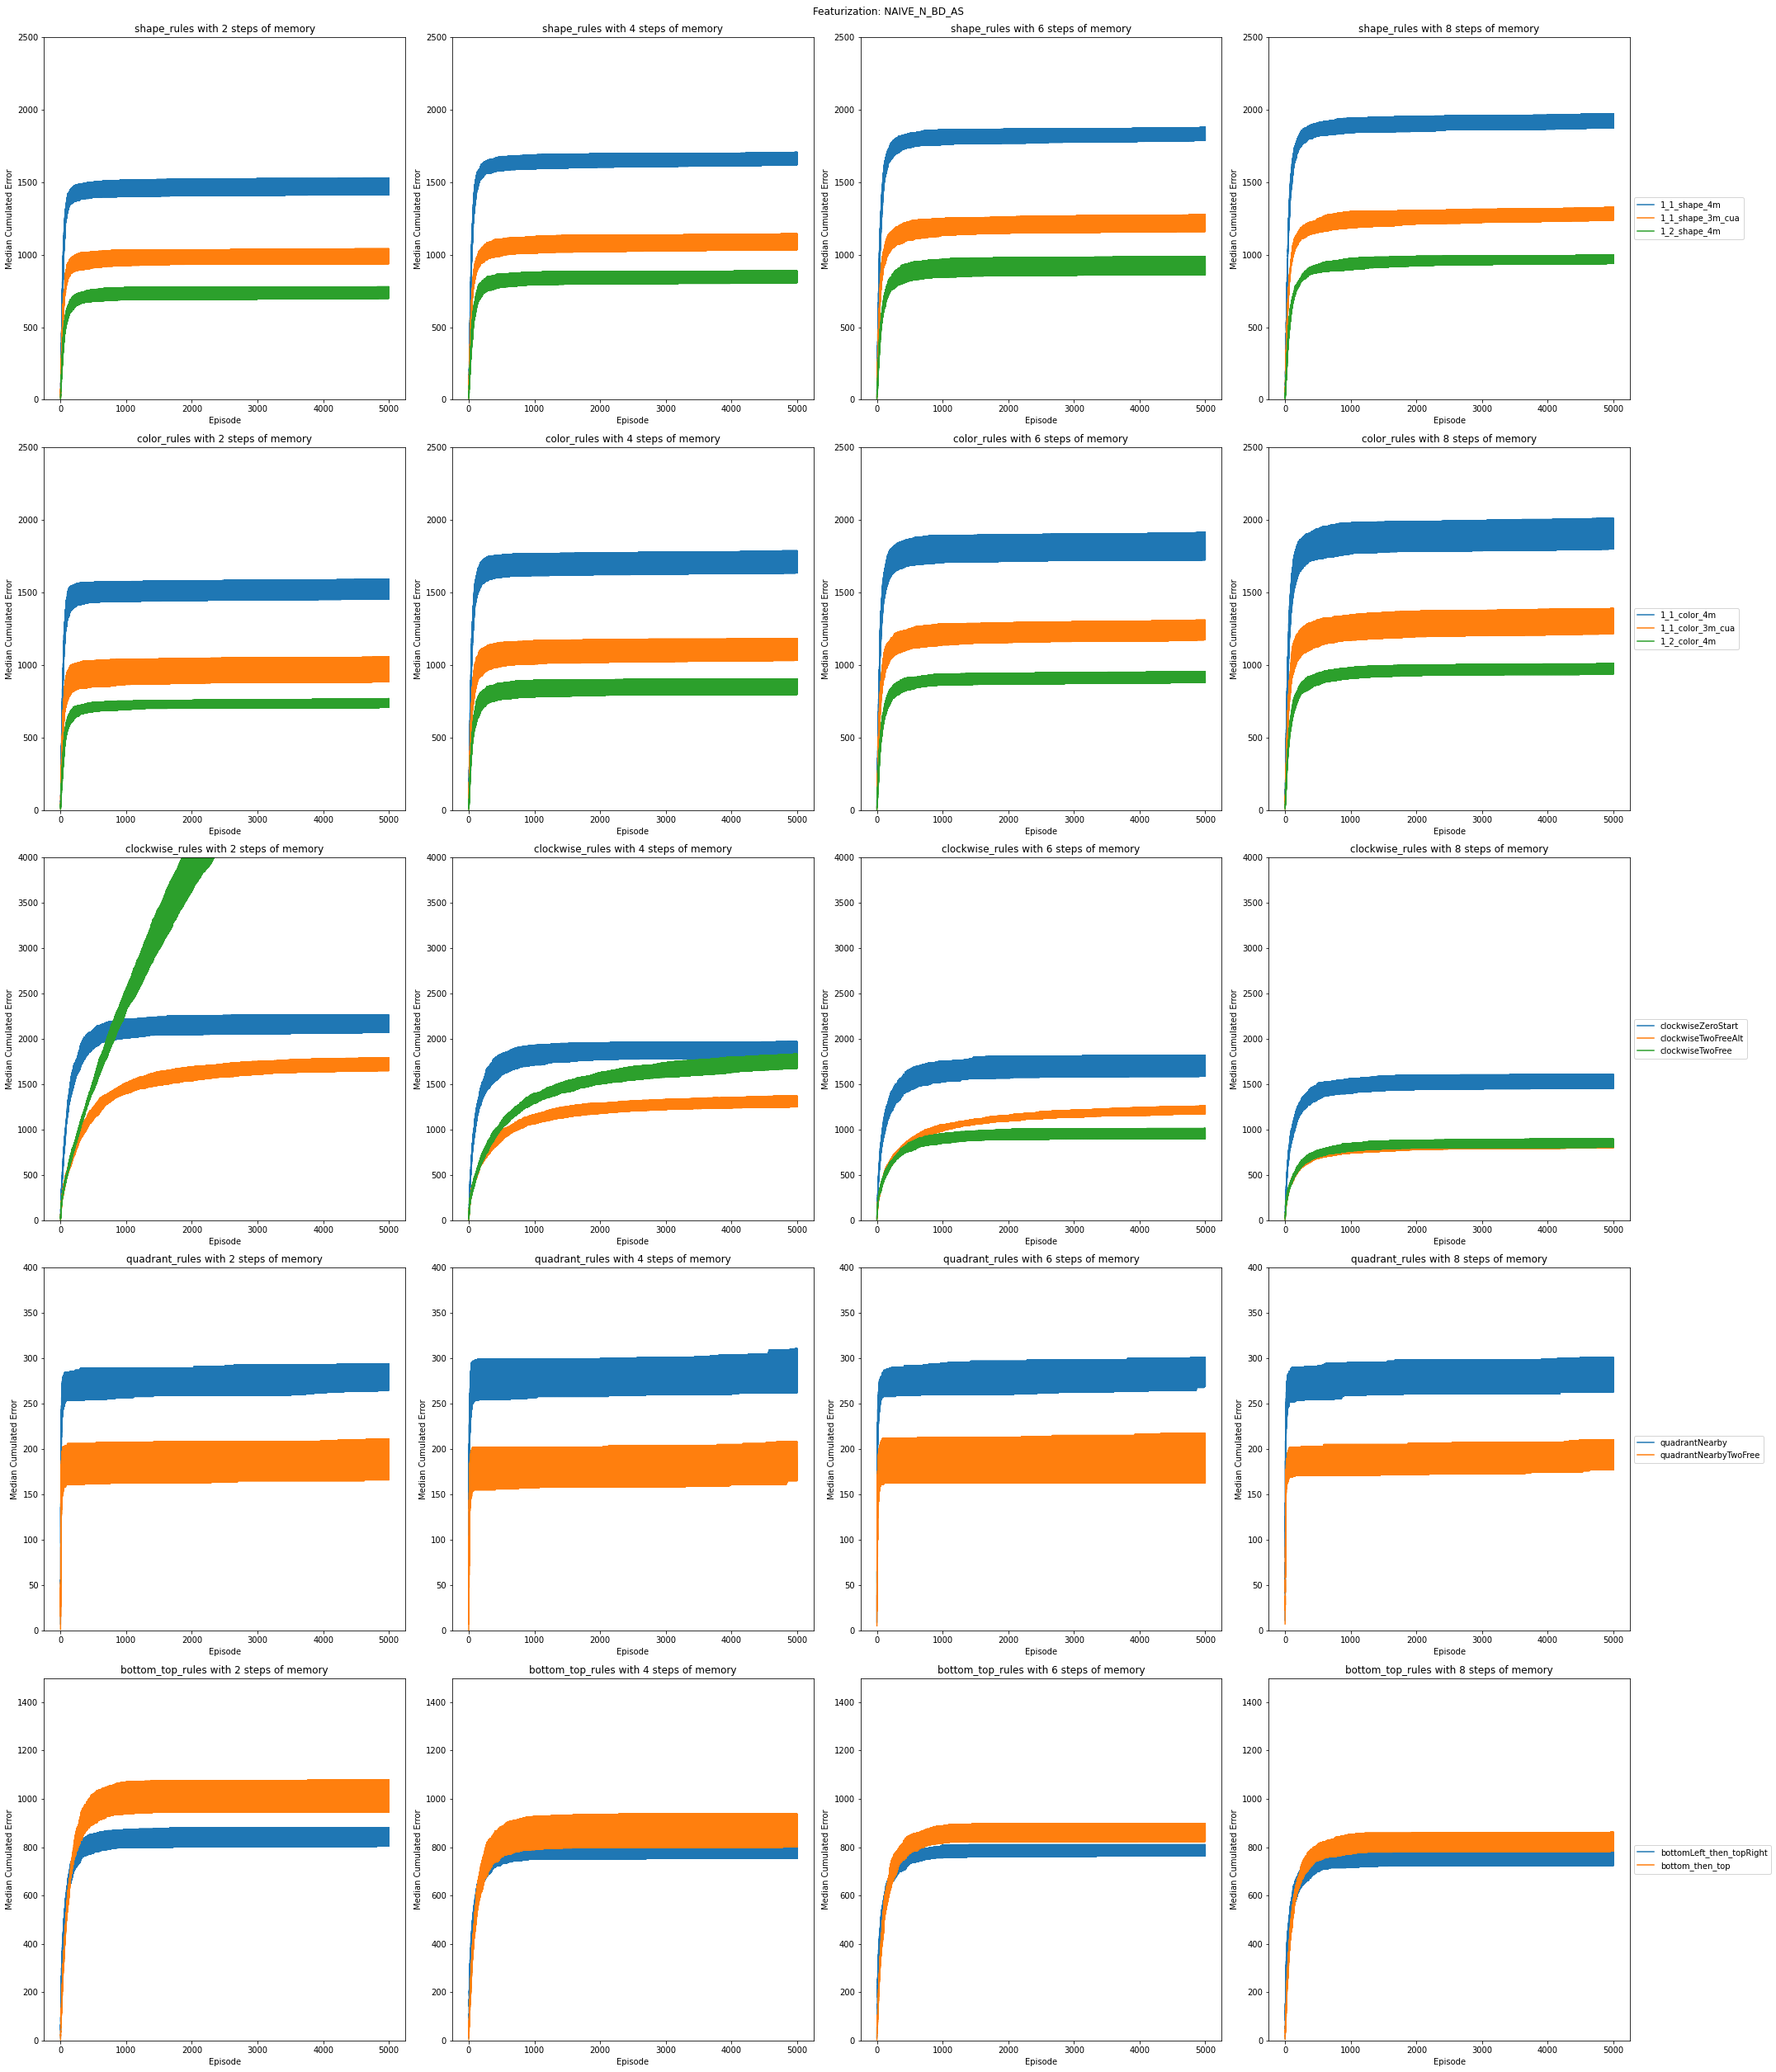

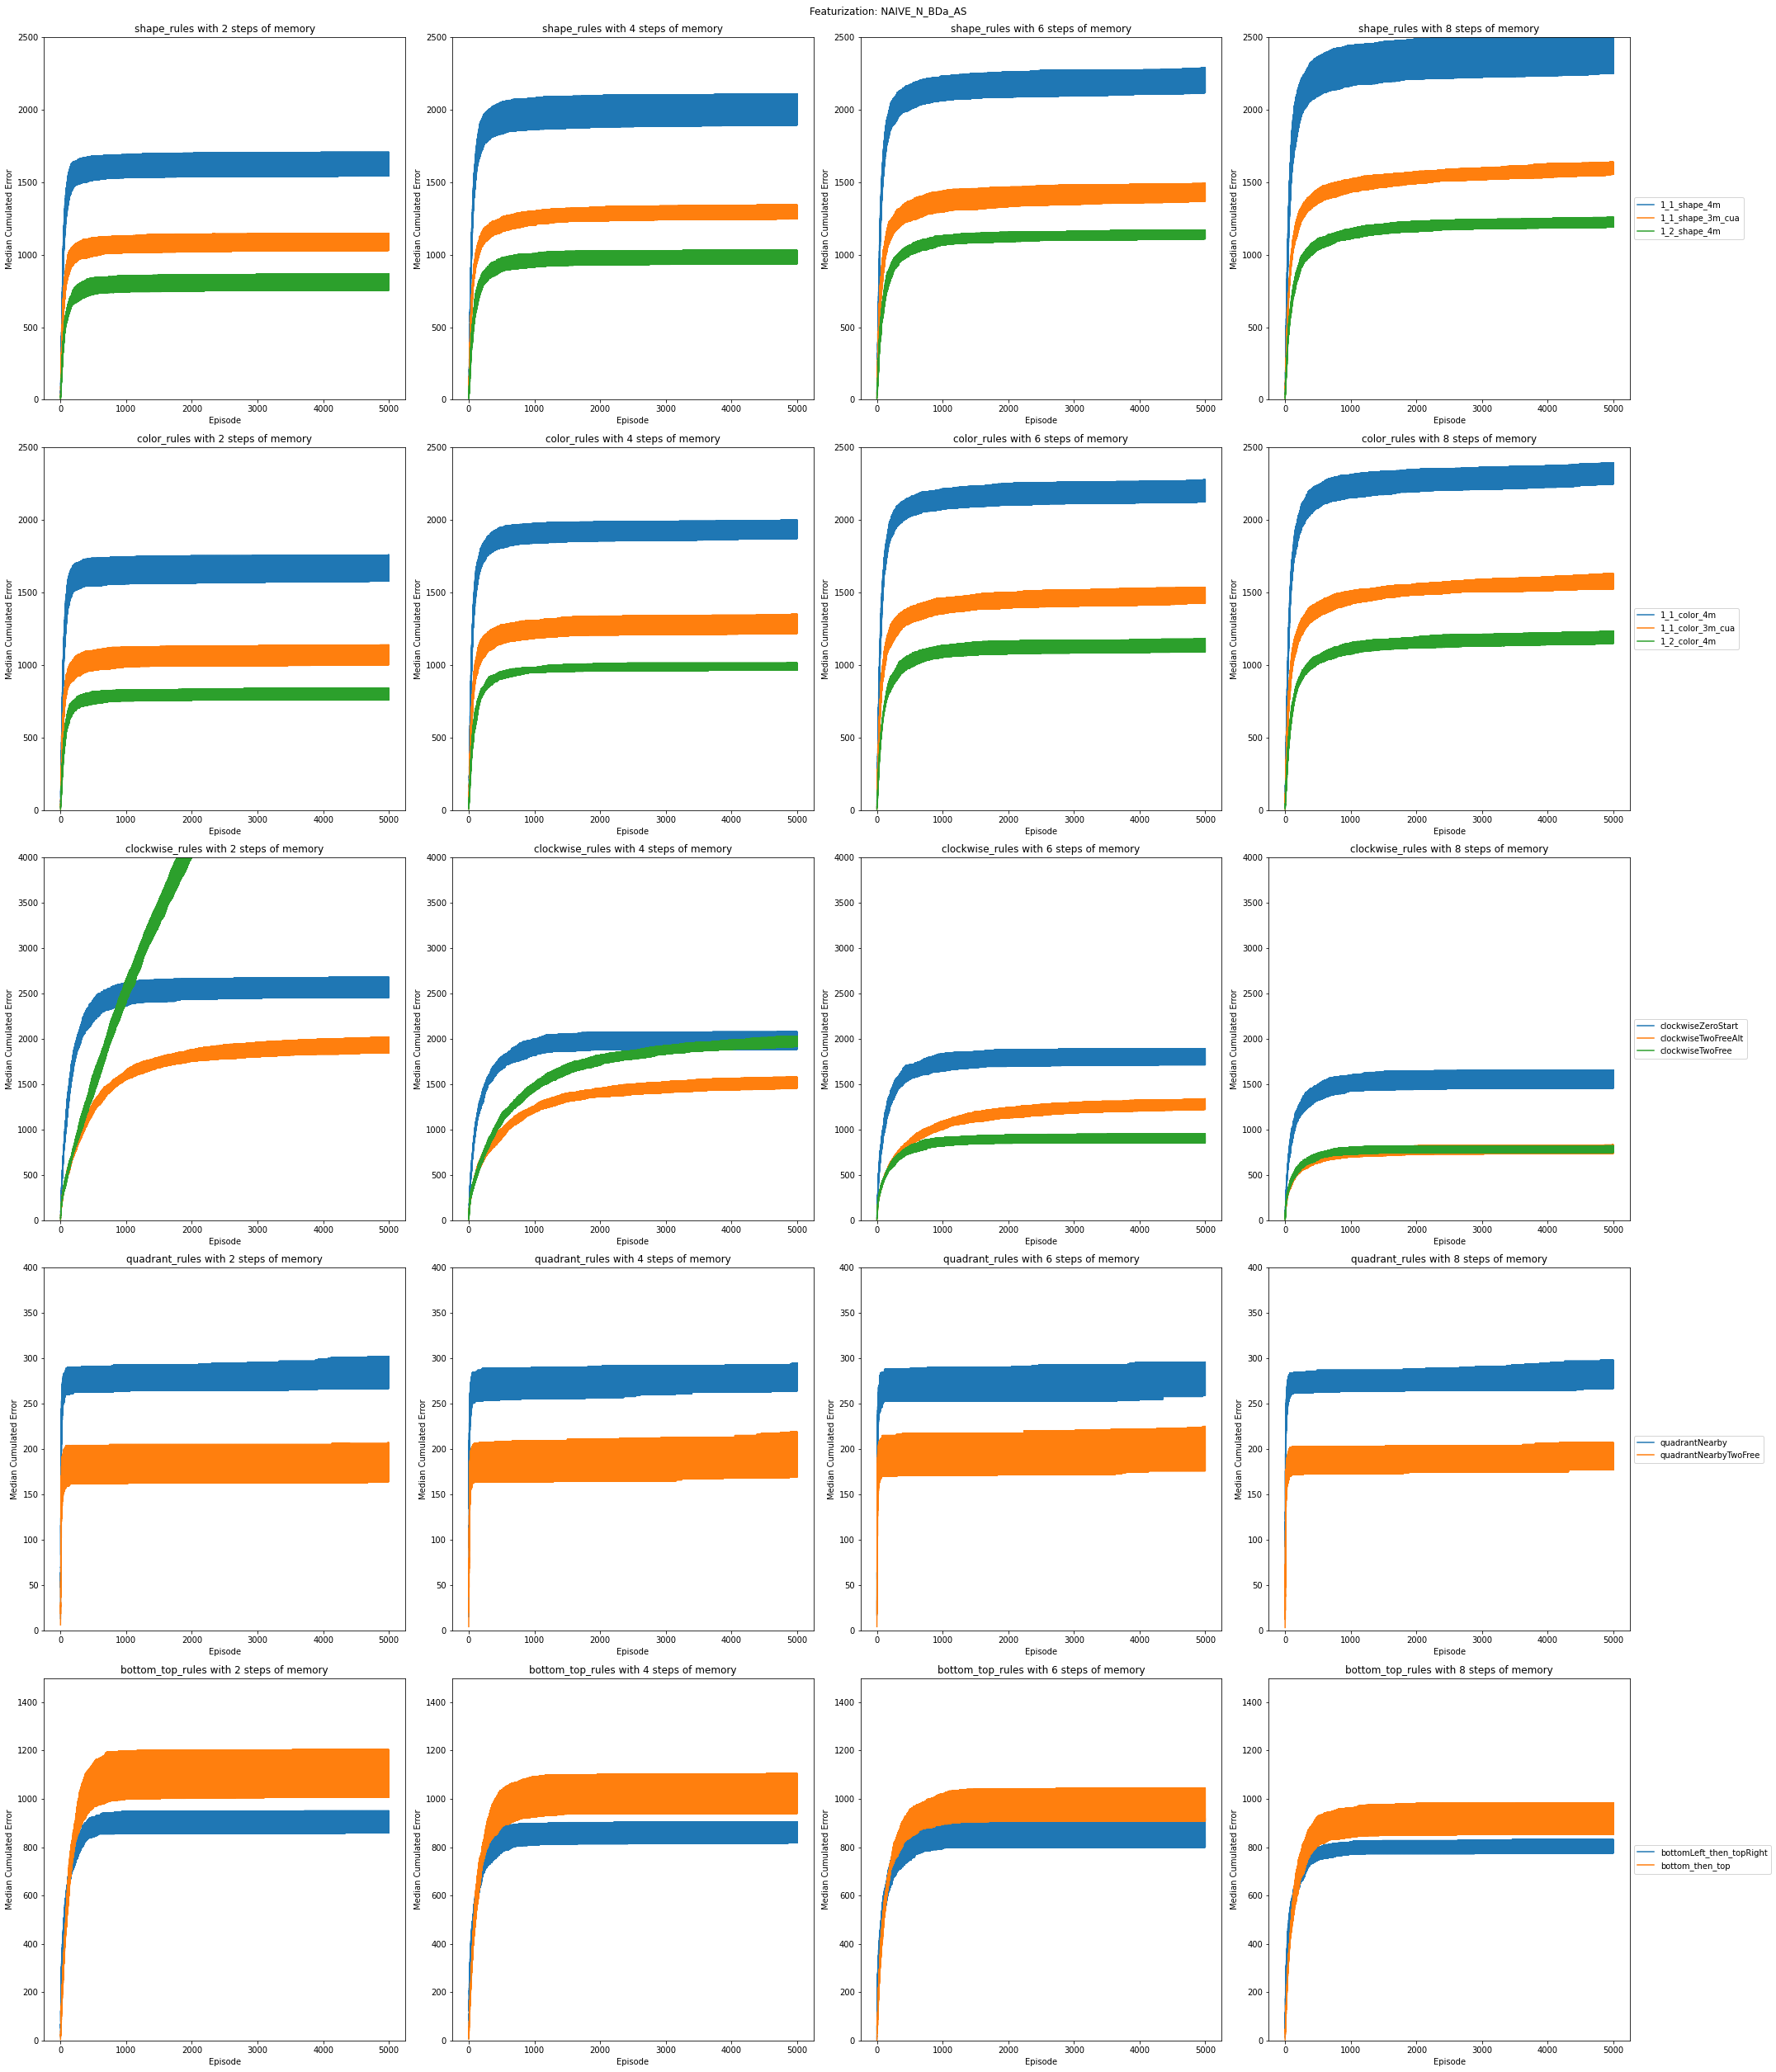

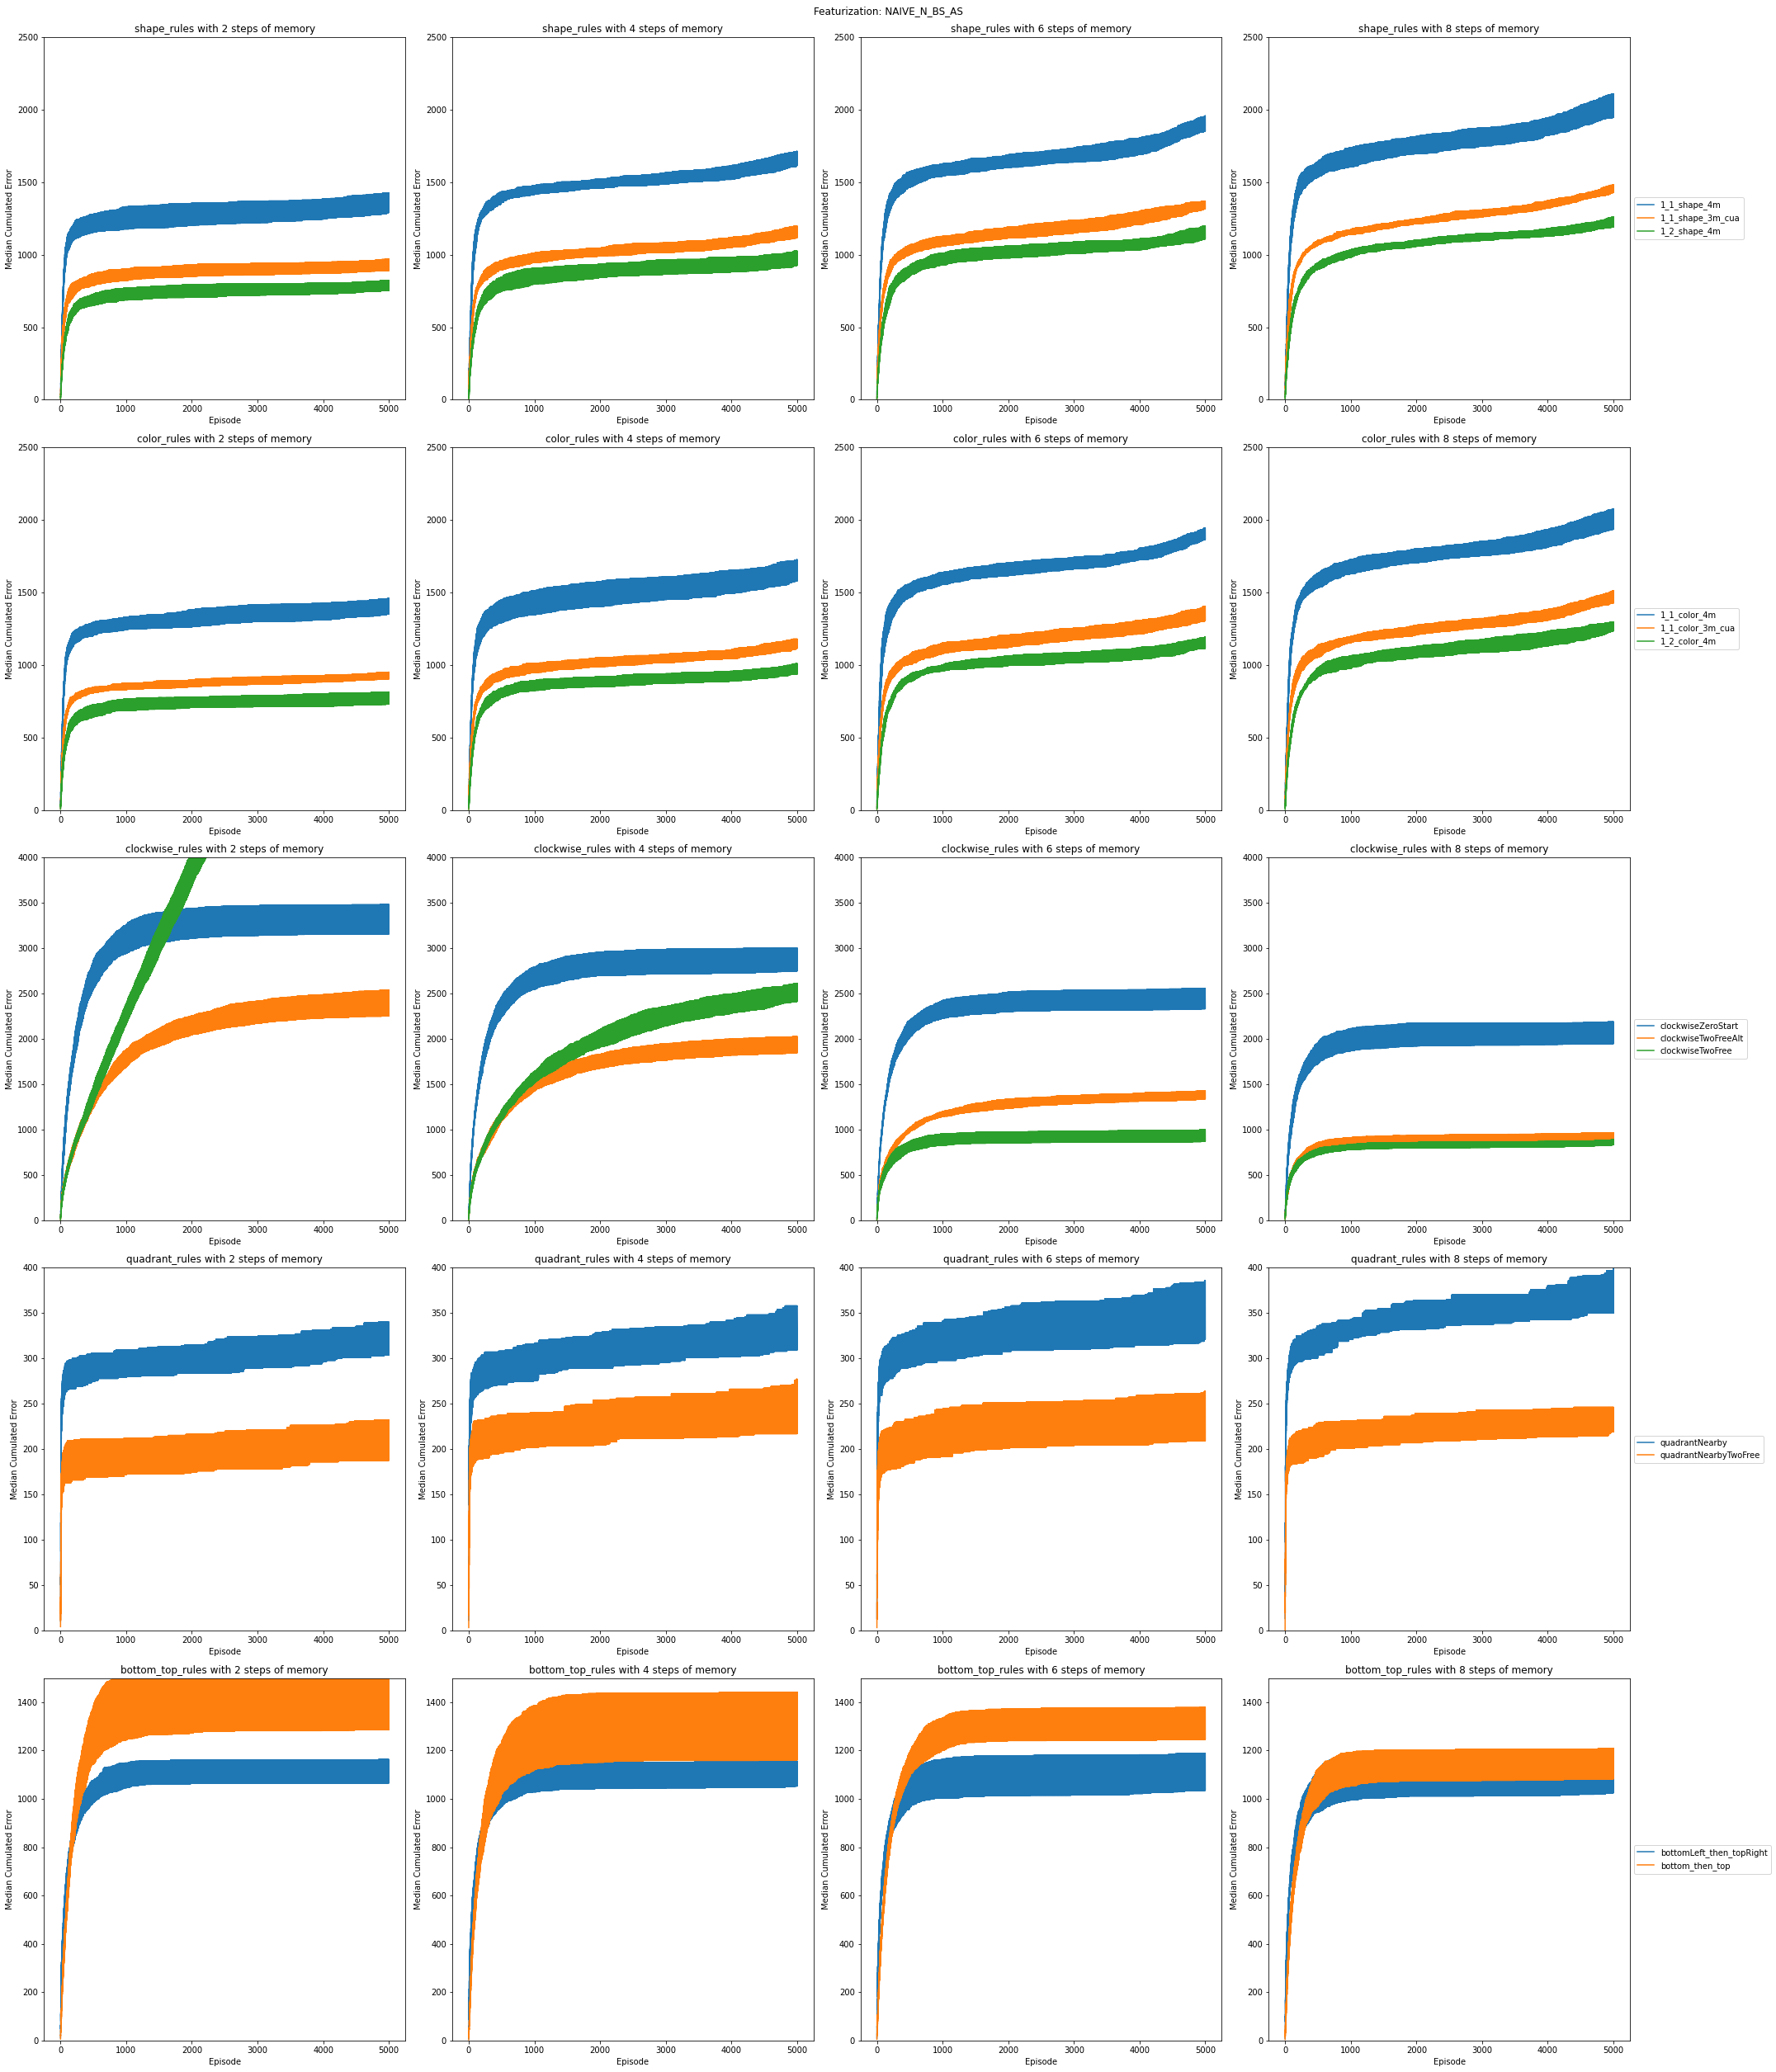

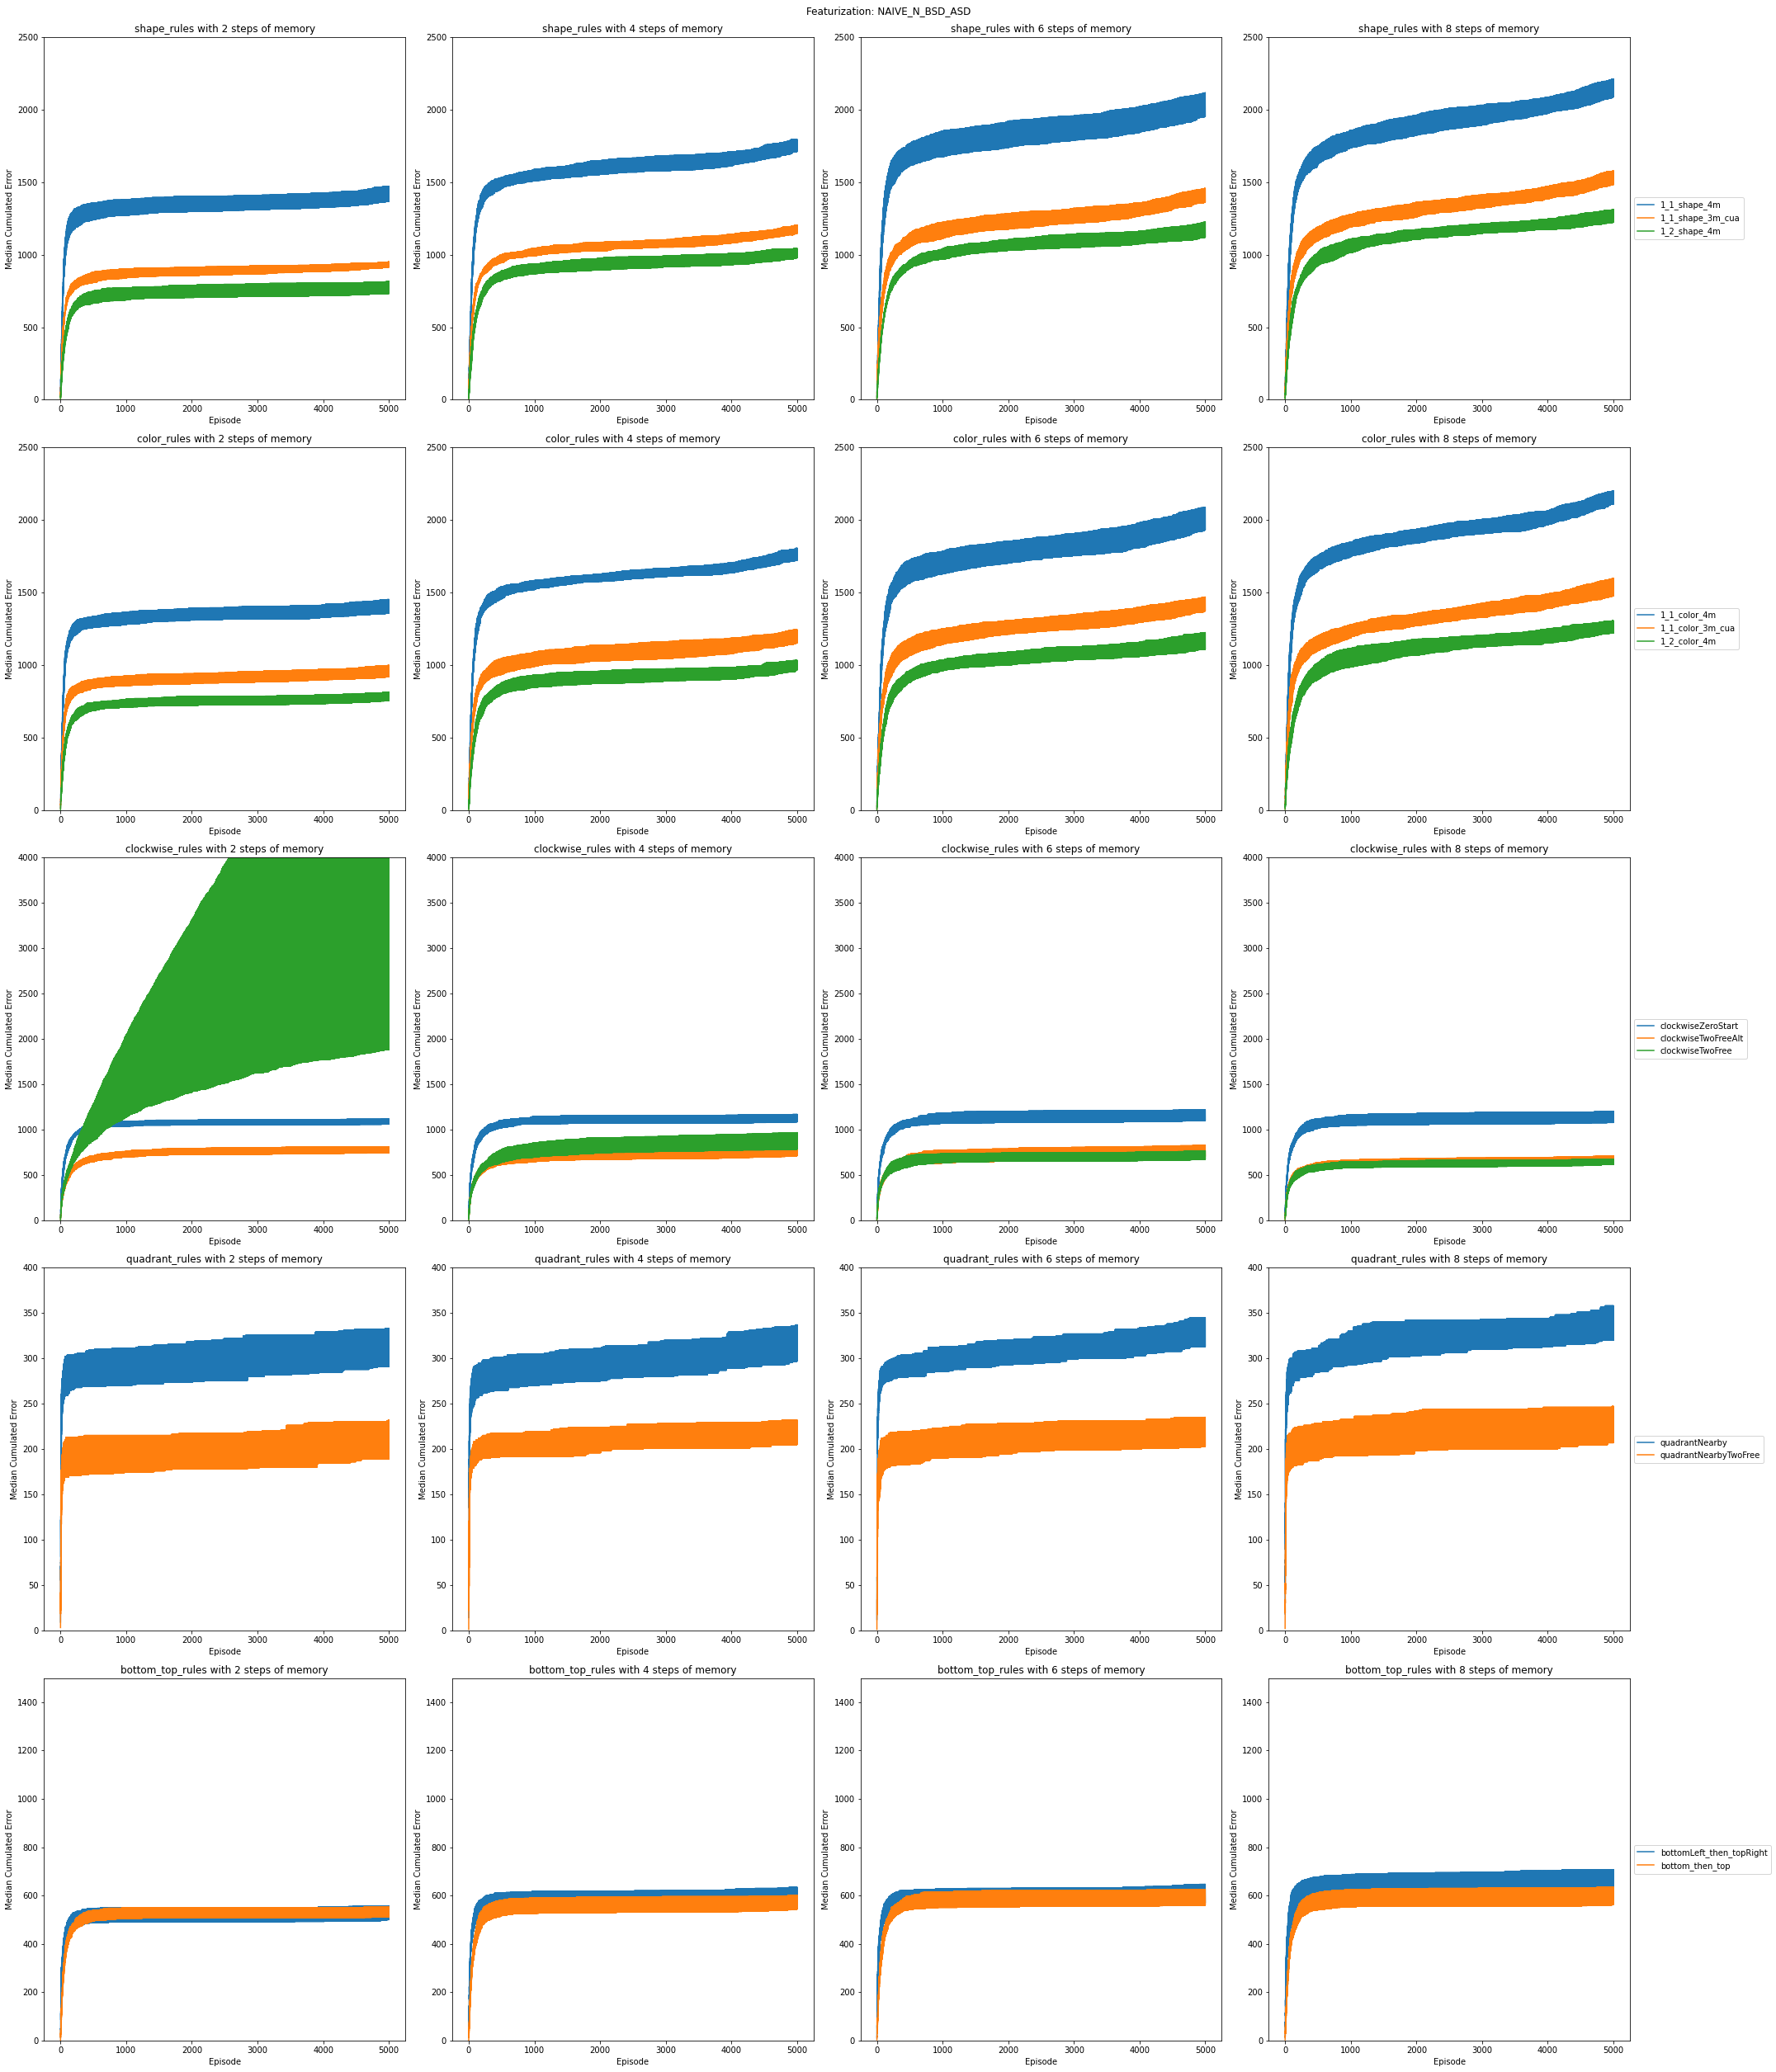

In [6]:
# all lines
feat_dir = plot_dir+"featurizations/"
if not os.path.exists(feat_dir):
    os.mkdir(feat_dir)

for feat in feats:
    temp_df = episode_results_df.query("featurization==@feat").copy()
    fig = plt.figure(figsize=(30,35))
    steps = terminal_results_df.memory.unique()
    gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
    for idx,step in enumerate(steps):
        results_df = temp_df.query("memory==@step")
        for i in range(len(rules_list)):
            sub_dict = rules_list[i]
            sub_list = sub_dict["rules"]
            name = sub_dict["name"]
            ax = fig.add_subplot(gs[i,idx])
            if not(step==8):
                ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", estimator=None,hue="rule",hue_order=sub_list,legend=False)
            else:
                ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",estimator=None,hue="rule",hue_order=sub_list)
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(name+" with {} steps of memory".format(str(step)))
            ax.set_ylim(sub_dict["y"])
            ax.set_ylabel("Median Cumulated Error")
            ax.set_xlabel("Episode")
    fig.suptitle("Featurization: "+feat,y=.995)
    fig.tight_layout()
    #plt.savefig(feat_dir+feat+'_all_rules.pdf',bbox_inches='tight',facecolor='w')
    #plt.close(fig)

In [12]:
rule_dir = plot_dir+"rules/"
if not os.path.exists(rule_dir):
    os.mkdir(rule_dir)

from math import ceil
for sub_list in rules_list:
    list_rules = sub_list["rules"]
    name = sub_list["name"]
    fig = plt.figure(figsize=(30,7*len(list_rules)))
    gs = GridSpec(nrows=len(list_rules),ncols=len(steps))
    for i,rule in enumerate(list_rules):
        df = episode_results_df.query("rule==@rule").copy()
        max_y = ceil(df.cumulative_error.max()/100)*100+50
        for idx,step in enumerate(steps):
            ax = fig.add_subplot(gs[i,idx])
            ax=sns.lineplot(data=df.query("memory==@step"),y="cumulative_error",x="episode", errorbar=("ci",95),estimator=np.median,n_boot=100,hue="featurization",hue_order=feats)
            #ax.legend(loc='lower right')
            ax.set_title(rule+" with {} steps of memory".format(str(step)))
            ax.set_ylim(0,max_y)
            ax.set_ylabel("Median Cumulated Error")
            ax.set_xlabel("Episode")
    fig.suptitle(name,y=.995)
    fig.tight_layout()
    plt.savefig(rule_dir+name+'_all_featurizations.pdf',bbox_inches='tight',facecolor='w')
    plt.close(fig)


In [111]:
stat_dir = plot_dir+"stat_tests/"
if not os.path.exists(stat_dir):
    os.mkdir(stat_dir)

comparisons = 78
alpha = 0.05
for feat in feats:
    fig = plt.figure(figsize=(50,60))
    gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
    for s_id,step in enumerate(steps):
        df = terminal_results_df.query("featurization==@feat and memory==@step").copy()
        rules = df.rule.unique()
        cat_list = []
        for rule in rules:
            med_df = {}
            med_df["rule"]=rule
            med_df["med_cumulative_error"]=df.query("rule==@rule").cumulative_error.median()
            #print(med_df)
            cat_list.append(pd.DataFrame.from_dict([med_df]))
        med_results_df = pd.concat(cat_list,ignore_index=True)
        #display(med_results_df)
        #display(med_results_df.sort_values(by="med_cumulative_error",ascending=False))
        sorted_rules = med_results_df.sort_values(by="med_cumulative_error",ascending=False).rule.tolist()
        sorted_med_err = med_results_df.sort_values(by="med_cumulative_error",ascending=False).med_cumulative_error.tolist()
        sorted_rules_labeled = []
        for i in range(len(sorted_rules)):
            sorted_rules_labeled.append(sorted_rules[i]+" ({})".format(str(int(sorted_med_err[i]))))
        #print(sorted_rules)
        mw_heatmap = np.empty((len(rules),len(rules)))
        mw_heatmap[:]=np.nan
        ks_heatmap = np.empty((len(rules),len(rules)))
        ks_heatmap[:]=np.nan
        for idx,i in enumerate(sorted_rules):
            for idy,j in enumerate(sorted_rules):
                a = df.query("rule==@i").cumulative_error.to_numpy(dtype=int)
                b = df.query("rule==@j").cumulative_error.to_numpy(dtype=int)
                if np.isnan(mw_heatmap[idy,idx]):
                    u,p1 = mannwhitneyu(x=a,y=b,method="asymptotic")
                    mw_heatmap[idx,idy]=np.around(p1,decimals=5)
                if np.isnan(ks_heatmap[idy,idx]):
                    _,p2 = ks_2samp(a,b,mode='asymp')
                    ks_heatmap[idx,idy]=np.around(p2,decimals=5)
        ax0 = fig.add_subplot(gs[s_id,0])
        ax1 = fig.add_subplot(gs[s_id,1])
        green = sns.light_palette("seagreen", reverse=True, as_cmap=True)
        green.set_over('red')
        sns.heatmap(ax=ax0,data=mw_heatmap,annot=True,yticklabels=sorted_rules_labeled,linewidth=.5,vmin=0,vmax=alpha/comparisons,cmap=green,cbar=False,square=True,fmt='.5f')
        sns.heatmap(ax=ax1,data=ks_heatmap,annot=True,yticklabels=sorted_rules_labeled,linewidth=.5,vmin=0,vmax=alpha/comparisons,cmap=green,cbar=False,square=True,fmt='.5f')
        ax0.xaxis.tick_top()
        ax1.xaxis.tick_top()
        ax0.set_xticklabels(labels=sorted_rules_labeled,rotation=45,ha='left')
        ax0.set_title("Two-Sided Mann-Whitney p-values, memory={}".format(str(step)))
        ax1.set_xticklabels(labels=sorted_rules_labeled,rotation=45,ha='left')
        ax1.set_title("Two-Sided Kolmogorov-Smirnov p-values, memory={}".format(str(step)))
    fig.suptitle('{featlabel} statistical tests\nmedian cumulated error values noted in parentheses for each rule\np-values rounded to 5 decimal places, signficant values after Bonferroni correction are marked green (<{siglabel:.5f})\n'.format(featlabel=feat,siglabel=alpha/comparisons),x=.25,y=.995,ha='center')
    fig.tight_layout()
    plt.savefig(stat_dir+feat+'.pdf',bbox_inches='tight',facecolor='w')
    plt.close(fig)


In [25]:
# Make final ranking for ML

ser_list = []
for feat in feats:
    for step in steps:
        df = terminal_results_df.query("featurization==@feat and memory==@step").copy()
        label = feat+"_n"+str(step)
        entry_list=[]
        for rule in df.rule.unique():
            med = int(df.query("rule==@rule").cumulative_error.median())
            entry = {}
            entry["algo"]=label
            entry["rule"]=rule
            entry["med_err"]=med
            entry_list.append(pd.DataFrame.from_dict([entry]))
        med_results_df = pd.concat(entry_list,ignore_index=True)
        med_results_df.sort_values(by='med_err',ascending=False,inplace=True)
        med_results_df[str(label)]=med_results_df.rule
        col_ser = med_results_df[str(label)].copy()
        col_ser.reset_index(inplace=True,drop=True)
        ser_list.append(col_ser)
df.head()
med_results_df.head()
#display(col_ser)


0                 1_1_shape_4m
1                 1_1_color_4m
2             1_1_shape_3m_cua
3             1_1_color_3m_cua
4                 1_2_color_4m
5                 1_2_shape_4m
6           clockwiseZeroStart
7          clockwiseTwoFreeAlt
8             clockwiseTwoFree
9     bottomLeft_then_topRight
10             bottom_then_top
11              quadrantNearby
12       quadrantNearbyTwoFree
Name: NAIVE_N_BSD_ASD_n8, dtype: object

In [26]:
test = pd.concat(ser_list,axis=1)
display(test)

,NAIVE_N_BD_AD_n2,NAIVE_N_BD_AD_n4,NAIVE_N_BD_AD_n6,NAIVE_N_BD_AD_n8,NAIVE_N_BS_AD_n2,NAIVE_N_BS_AD_n4,NAIVE_N_BS_AD_n6,NAIVE_N_BS_AD_n8,NAIVE_N_BD_AS_n2,NAIVE_N_BD_AS_n4,...,NAIVE_N_BDa_AS_n6,NAIVE_N_BDa_AS_n8,NAIVE_N_BS_AS_n2,NAIVE_N_BS_AS_n4,NAIVE_N_BS_AS_n6,NAIVE_N_BS_AS_n8,NAIVE_N_BSD_ASD_n2,NAIVE_N_BSD_ASD_n4,NAIVE_N_BSD_ASD_n6,NAIVE_N_BSD_ASD_n8
0,clockwiseTwoFree,1_1_color_4m,1_1_color_4m,1_1_color_4m,clockwiseTwoFree,1_1_color_4m,1_1_color_4m,1_1_color_4m,clockwiseTwoFree,clockwiseZeroStart,...,1_1_shape_4m,1_1_shape_4m,clockwiseTwoFree,clockwiseZeroStart,clockwiseZeroStart,clockwiseZeroStart,clockwiseTwoFree,1_1_shape_4m,1_1_color_4m,1_1_shape_4m
1,1_1_color_4m,1_1_shape_4m,1_1_shape_4m,1_1_shape_4m,1_1_shape_4m,1_1_shape_4m,1_1_shape_4m,1_1_shape_4m,clockwiseZeroStart,1_1_shape_4m,...,1_1_color_4m,1_1_color_4m,clockwiseZeroStart,clockwiseTwoFree,1_1_shape_4m,1_1_color_4m,1_1_color_4m,1_1_color_4m,1_1_shape_4m,1_1_color_4m
2,1_1_shape_4m,1_1_color_3m_cua,1_1_shape_3m_cua,1_1_shape_3m_cua,1_1_color_4m,clockwiseZeroStart,1_1_shape_3m_cua,1_1_color_3m_cua,clockwiseTwoFreeAlt,1_1_color_4m,...,clockwiseZeroStart,1_1_shape_3m_cua,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,1_1_color_4m,1_1_shape_4m,1_1_shape_4m,clockwiseZeroStart,1_1_shape_3m_cua,1_1_shape_3m_cua
3,1_1_shape_3m_cua,1_1_shape_3m_cua,1_1_color_3m_cua,1_1_color_3m_cua,clockwiseZeroStart,1_1_shape_3m_cua,1_1_color_3m_cua,1_1_shape_3m_cua,1_1_color_4m,clockwiseTwoFree,...,1_1_color_3m_cua,1_1_color_3m_cua,bottom_then_top,1_1_color_4m,clockwiseTwoFreeAlt,1_1_shape_3m_cua,clockwiseZeroStart,1_1_shape_3m_cua,1_1_color_3m_cua,1_1_color_3m_cua
4,1_1_color_3m_cua,1_2_color_4m,1_2_color_4m,1_2_color_4m,1_1_color_3m_cua,1_1_color_3m_cua,clockwiseZeroStart,clockwiseZeroStart,1_1_shape_4m,clockwiseTwoFreeAlt,...,1_1_shape_3m_cua,clockwiseZeroStart,1_1_shape_4m,1_1_shape_4m,bottom_then_top,1_1_color_3m_cua,1_1_shape_3m_cua,1_1_color_3m_cua,clockwiseZeroStart,1_2_color_4m
5,clockwiseZeroStart,1_2_shape_4m,1_2_shape_4m,1_2_shape_4m,1_1_shape_3m_cua,1_2_shape_4m,1_2_color_4m,1_2_color_4m,bottom_then_top,1_1_shape_3m_cua,...,clockwiseTwoFreeAlt,1_2_color_4m,1_1_color_4m,bottom_then_top,1_1_shape_3m_cua,bottom_then_top,1_1_color_3m_cua,1_2_shape_4m,1_2_color_4m,1_2_shape_4m
6,1_2_color_4m,clockwiseZeroStart,clockwiseZeroStart,clockwiseZeroStart,1_2_color_4m,1_2_color_4m,1_2_shape_4m,1_2_shape_4m,1_1_color_3m_cua,1_1_color_3m_cua,...,1_2_color_4m,1_2_shape_4m,bottomLeft_then_topRight,bottomLeft_then_topRight,1_1_color_3m_cua,1_2_color_4m,1_2_color_4m,1_2_color_4m,1_2_shape_4m,clockwiseZeroStart
7,1_2_shape_4m,clockwiseTwoFree,clockwiseTwoFree,clockwiseTwoFree,1_2_shape_4m,clockwiseTwoFree,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,1_1_shape_3m_cua,bottom_then_top,...,1_2_shape_4m,bottom_then_top,1_1_color_3m_cua,1_1_shape_3m_cua,bottomLeft_then_topRight,bottomLeft_then_topRight,1_2_shape_4m,clockwiseTwoFree,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt
8,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,clockwiseTwoFree,clockwiseTwoFree,bottomLeft_then_topRight,1_2_color_4m,...,bottom_then_top,bottomLeft_then_topRight,1_1_shape_3m_cua,1_1_color_3m_cua,1_2_color_4m,1_2_shape_4m,clockwiseTwoFreeAlt,clockwiseTwoFreeAlt,clockwiseTwoFree,clockwiseTwoFree
9,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight,1_2_shape_4m,1_2_shape_4m,...,clockwiseTwoFree,clockwiseTwoFree,1_2_shape_4m,1_2_color_4m,1_2_shape_4m,clockwiseTwoFreeAlt,bottom_then_top,bottomLeft_then_topRight,bottomLeft_then_topRight,bottomLeft_then_topRight


In [31]:
results_list = []
for feat in feats:
    for step in steps:
        df = terminal_results_df.query("featurization==@feat and memory==@step").copy()
        label = feat+"_n"+str(step)
        entry_list=[]
        for rule in df.rule.unique():
            med = int(df.query("rule==@rule").cumulative_error.median())
            entry = {}
            entry["algo"]=label
            entry["rule"]=rule
            entry["med_err"]=med
            entry_list.append(pd.DataFrame.from_dict([entry]))
        med_results_df = pd.concat(entry_list,ignore_index=True)
        med_results_df.sort_values(by='med_err',ascending=False,inplace=True)
        med_results_df.reset_index(inplace=True,drop=True)
        med_results_df['rank']=med_results_df.index+1
        results_list.append(med_results_df)
total_df = pd.concat(results_list,ignore_index=True)
display(total_df[0:20])

,algo,rule,med_err,rank
0,NAIVE_N_BD_AD_n2,clockwiseTwoFree,2169,1
1,NAIVE_N_BD_AD_n2,1_1_color_4m,1629,2
2,NAIVE_N_BD_AD_n2,1_1_shape_4m,1618,3
3,NAIVE_N_BD_AD_n2,1_1_shape_3m_cua,1048,4
4,NAIVE_N_BD_AD_n2,1_1_color_3m_cua,1046,5
5,NAIVE_N_BD_AD_n2,clockwiseZeroStart,816,6
6,NAIVE_N_BD_AD_n2,1_2_color_4m,793,7
7,NAIVE_N_BD_AD_n2,1_2_shape_4m,793,8
8,NAIVE_N_BD_AD_n2,clockwiseTwoFreeAlt,606,9
9,NAIVE_N_BD_AD_n2,bottomLeft_then_topRight,435,10


In [40]:
pivoted = total_df.pivot(index='rule',columns = 'algo',values='rank').rename_axis(mapper="rule_num",axis=1).reset_index().rename_axis(None,axis=1)
algos=total_df.algo.unique()
display(pivoted)

,rule,NAIVE_N_BD_AD_n2,NAIVE_N_BD_AD_n4,NAIVE_N_BD_AD_n6,NAIVE_N_BD_AD_n8,NAIVE_N_BD_AS_n2,NAIVE_N_BD_AS_n4,NAIVE_N_BD_AS_n6,NAIVE_N_BD_AS_n8,NAIVE_N_BDa_AS_n2,...,NAIVE_N_BSD_ASD_n6,NAIVE_N_BSD_ASD_n8,NAIVE_N_BS_AD_n2,NAIVE_N_BS_AD_n4,NAIVE_N_BS_AD_n6,NAIVE_N_BS_AD_n8,NAIVE_N_BS_AS_n2,NAIVE_N_BS_AS_n4,NAIVE_N_BS_AS_n6,NAIVE_N_BS_AS_n8
0,1_1_color_3m_cua,5,3,4,4,7,7,5,4,8,...,4,4,5,5,4,3,8,9,7,5
1,1_1_color_4m,2,1,1,1,4,3,2,2,5,...,1,2,3,1,1,1,6,4,3,2
2,1_1_shape_3m_cua,4,4,3,3,8,6,4,5,7,...,3,3,6,4,3,4,9,8,6,4
3,1_1_shape_4m,3,2,2,2,5,2,1,1,4,...,2,1,2,2,2,2,5,5,2,3
4,1_2_color_4m,7,5,5,5,11,9,8,7,11,...,6,5,7,7,6,6,11,10,9,7
5,1_2_shape_4m,8,6,6,6,10,10,9,6,10,...,7,6,8,6,7,7,10,11,10,9
6,bottomLeft_then_topRight,10,10,10,10,9,11,11,11,9,...,10,10,10,10,10,10,7,7,8,8
7,bottom_then_top,11,11,11,11,6,8,10,9,6,...,11,11,11,11,11,11,4,6,5,6
8,clockwiseTwoFree,1,8,8,8,1,4,7,8,1,...,9,9,1,8,9,9,1,2,11,11
9,clockwiseTwoFreeAlt,9,9,9,9,3,5,6,10,3,...,8,8,9,9,8,8,3,3,4,10


In [44]:
import plotly.express as px
fig = px.parallel_coordinates(pivoted[0:1], color=pivoted.index[0:1],
                              dimensions=algos,
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=6,
                              height=600,
                              width=1000)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

